### Wesley Janson and Drew Keller
## STAT 27420 Final Project
# Modeling Code

In [1]:
# Load in relevant packages

import pandas as pd
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from data_utils import read_data, prep_features, evaluate_predictions, rebin_outcome, summarize_predictions, evaluate_multilevel_predictions
import numpy as np
import matplotlib.pyplot as plt

# set random seed for numpy
RANDOM_SEED=69
np.random.seed(RANDOM_SEED)


DATA_PATH = '../paper_replication_data/new_data.csv'  # Drew's path

In [2]:
from load_data import data, categorical_vars, cts_vars, other_vars

# loading data from online takes ~20 seconds
# to speed up, save data locally and load from there:

#data.to_csv(DATA_PATH,index=False)  # run this once

Excluding 2262 observations that did not answer 1 year price change question.


In [3]:
# Categorical_vars and cts_vars are lists of vars in each category.
# Other_vars are ID and date variables (categorical_vars + cts_vars + other_vars = all vars)

data = read_data(DATA_PATH)  # use this over pd.read_csv, because this handles types

In [4]:
data.treatment_bins.value_counts(dropna=False)  # check that we have a balanced dataset

0-5      185749
5-10      31599
NaN       18725
10-15      6010
15-20      2836
20+        2368
Name: treatment_bins, dtype: int64

In [5]:
data.durable_purchase.value_counts(dropna=False)  # check that we have a balanced dataset

Good          171775
Bad            54240
Don't know     10247
Neutral         9243
Refused         1782
Name: durable_purchase, dtype: int64

***Regression***

In [6]:
# prep features for modeling; use regression=True for regression models
data_regression, treatment_vars, confounder_vars = prep_features(data,regression=True,missing_values='drop cts')  
X = data_regression[confounder_vars+["price_change_amt_next_yr"]]
Y = data_regression['durable_purchase']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

Excluding 12029 observations that refused or didn't know durable purchase question.
Excluding 70815 observations that did not answer confounder questions.
Excluding 9476 observations that did not answer price change amount question.


In [7]:
# Model 1a: ordered probit (same as Bachmann et al.) with cts treatment
mod_prob1a = OrderedModel(y_train,X_train,distr='probit')
res_prob1a = mod_prob1a.fit(method='bfgs')
res_prob1a.summary()

Optimization terminated successfully.
         Current function value: 0.613155
         Iterations: 142
         Function evaluations: 143
         Gradient evaluations: 143


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:       durable_purchase   Log-Likelihood:                -76015.
Model:                   OrderedModel   AIC:                         1.521e+05
Method:            Maximum Likelihood   BIC:                         1.524e+05
Date:                Sun, 04 Dec 2022                                         
Time:                        13:23:47                                         
No. Observations:              123973                                         
Df Residuals:                  123939                                         
Df Model:                          34                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
fed_funds_rate                           0.2239      0.006     38.545      0.000       0.212       0.235
unemployment_rate                       -0.1207      0.005    -24.452      0.000      -0.130      -0.111
cpi_1mo_lag                             -0.1546      0.006    -24.690      0.000      -0.167      -0.142
cpi_durable_1mo_lag                     -0.0829      0.006    -14.073      0.000      -0.094      -0.071
personal_finances_next_yr_Don't know    -0.1881      0.031     -5.980      0.000      -0.250      -0.126
personal_finances_next_yr_Refused       -0.2356      0.073     -3.247      0.001      -0.378      -0.093
personal_finances_next_yr_Same          -0.0602      0.009     -6.692      0.000      -0.078      -0.043
personal_finances_next_yr_Worse         -0.1900      0.014    -13.342      0.000      -0.218      -0.162
income_change_amt_next_yr               -0.0332      0.004     -7.873      0.000      -0.041      -0.025
conditions_next_yr_Don't know           -0.1513      0.038     -3.977      0.000      -0.226      -0.077
conditions_next_yr_Refused              -0.1890      0.075     -2.525      0.012      -0.336      -0.042
conditions_next_yr_Same                 -0.0375      0.010     -3.776      0.000      -0.057      -0.018
conditions_next_yr_Worse                -0.2332      0.013    -18.124      0.000      -0.258      -0.208
unemployment_next_yr_Higher             -0.2147      0.064     -3.355      0.001      -0.340      -0.089
unemployment_next_yr_Lower               0.0953      0.064      1.484      0.138      -0.031       0.221
unemployment_next_yr_Refused            -0.1105      0.130     -0.850      0.395      -0.365       0.144
unemployment_next_yr_Same                0.0483      0.064      0.756      0.450      -0.077       0.173
income_quintile_Lower middle            -0.0856      0.013     -6.447      0.000      -0.112      -0.060
income_quintile_Lowest                  -0.1610      0.015    -10.726      0.000      -0.190      -0.132
income_quintile_Middle                  -0.0656      0.012     -5.362      0.000      -0.090      -0.042
income_quintile_Upper middle            -0.0371      0.011     -3.240      0.001      -0.060      -0.015
age                                      0.0137      0.005      2.977      0.003       0.005       0.023
sex_Male                                 0.1023      0.008     12.604      0.000       0.086       0.118
education_Graduate school               -0.0273      0.012     -2.191      0.028      -0.052      -0.003
education_High school                    0.0167      0.012      1.429      0.153      -0.006       0.040
education_No high school                -0.2105      0.031     -6.824      0.000      -0.271      -0.150
education_Partial high school           -0.0260      0.022     -1.179      0.238      -0.069       0.017
education_So

In [8]:
y_test

54211    -1.0
12948     1.0
106443    1.0
179037    1.0
42451     0.0
         ... 
223908    1.0
75890     1.0
239600   -1.0
148680    1.0
37775     1.0
Name: durable_purchase, Length: 30994, dtype: float64

In [9]:
evaluate_predictions(res_prob1a, X_train, X_test, y_train, y_test, regression=True)

Baseline accuracy: 75.71%
Train accuracy: 75.91%
Test accuracy: 76.33%

Test predictions vs actual:


actual  predicted
-1.0    -1             746
         1            5845
 0.0    -1              27
         1             910
 1.0    -1             555
         1           22911
dtype: int64

In [10]:
X = data_regression[confounder_vars+treatment_vars]
Y = data_regression['durable_purchase']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

In [11]:
# Model 1b: ordered probit (same as Bachmann et al.) with cts treatment
mod_prob1b = OrderedModel(y_train,X_train,distr='probit')
res_prob1b = mod_prob1b.fit(method='bfgs')
res_prob1b.summary()

Optimization terminated successfully.
         Current function value: 0.613123
         Iterations: 153
         Function evaluations: 154
         Gradient evaluations: 154


/Users/drewkeller/opt/anaconda3/envs/stats/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:       durable_purchase   Log-Likelihood:                -76011.
Model:                   OrderedModel   AIC:                         1.521e+05
Method:            Maximum Likelihood   BIC:                         1.525e+05
Date:                Sun, 04 Dec 2022                                         
Time:                        13:26:43                                         
No. Observations:              123973                                         
Df Residuals:                  123935                                         
Df Model:                          38                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
fed_funds_rate                           0.2232        nan        nan        nan         nan         nan
unemployment_rate                       -0.1205        nan        nan        nan         nan         nan
cpi_1mo_lag                             -0.1548        nan        nan        nan         nan         nan
cpi_durable_1mo_lag                     -0.0831        nan        nan        nan         nan         nan
personal_finances_next_yr_Don't know    -0.1877        nan        nan        nan         nan         nan
personal_finances_next_yr_Refused       -0.2389        nan        nan        nan         nan         nan
personal_finances_next_yr_Same          -0.0610        nan        nan        nan         nan         nan
personal_finances_next_yr_Worse         -0.1904        nan        nan        nan         nan         nan
income_change_amt_next_yr               -0.0333        nan        nan        nan         nan         nan
conditions_next_yr_Don't know           -0.1510        nan        nan        nan         nan         nan
conditions_next_yr_Refused              -0.1895        nan        nan        nan         nan         nan
conditions_next_yr_Same                 -0.0381        nan        nan        nan         nan         nan
conditions_next_yr_Worse                -0.2334        nan        nan        nan         nan         nan
unemployment_next_yr_Higher             -0.2144        nan        nan        nan         nan         nan
unemployment_next_yr_Lower               0.0961        nan        nan        nan         nan         nan
unemployment_next_yr_Refused            -0.1104        nan        nan        nan         nan         nan
unemployment_next_yr_Same                0.0480        nan        nan        nan         nan         nan
income_quintile_Lower middle            -0.0858        nan        nan        nan         nan         nan
income_quintile_Lowest                  -0.1609        nan        nan        nan         nan         nan
income_quintile_Middle                  -0.0660        nan        nan        nan         nan         nan
income_quintile_Upper middle            -0.0372        nan        nan        nan         nan         nan
age                                      0.0140        nan        nan        nan         nan         nan
sex_Male                                 0.1034        nan        nan        nan         nan         nan
education_Graduate school               -0.0278        nan        nan        nan         nan         nan
education_High school                    0.0167        nan        nan        nan         nan         nan
education_No high school                -0.2118        nan        nan        nan         nan         nan
education_Partial high school           -0.0282        nan        nan        nan         nan         nan
education_So

In [12]:
evaluate_predictions(res_prob1b, X_train, X_test, y_train, y_test, regression=True)

Baseline accuracy: 75.71%
Train accuracy: 75.94%
Test accuracy: 76.31%

Test predictions vs actual:


actual  predicted
-1.0    -1             742
         1            5849
 0.0    -1              24
         1             913
 1.0    -1             555
         1           22911
dtype: int64

***Classification with XGBoost***

In [6]:
data_xgboost, treatment_vars, confounder_vars = prep_features(data,regression=False,missing_values='retain all')  

Excluding 12029 observations that refused or didn't know durable purchase question.
Excluding 16763 observations that did not answer price change amount question.


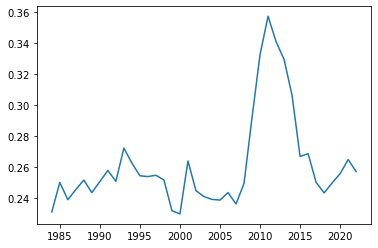

In [14]:
# only income_change_amt_next_yr has many missing values within our chosen cts confounders

# calculate percent missing for income_change_amt_next_yr by year 
pct_missing = data['income_change_amt_next_yr'].isnull().groupby(data.date.dt.year).agg(['mean','count'])
plt.plot(pct_missing["mean"])

In [15]:
# try dropping income_change_amt_next_yr
data_xgboost.drop(columns=['income_change_amt_next_yr'],inplace=True)  
confounder_vars.remove('income_change_amt_next_yr')

In [16]:
# Model 2: XGBoost with binned treatment

X = data_xgboost[confounder_vars+treatment_vars]
Y = data_xgboost['durable_purchase']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
model2 = xgb.XGBClassifier(learning_rate=0.07,max_depth=6,n_estimators=120,min_child_weight=3)
model2.fit(X_train, y_train)

/Users/drewkeller/opt/anaconda3/envs/stats/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:26:45] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.07, max_delta_step=0, max_depth=6,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=120, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
evaluate_predictions(model2, X_train, X_test, y_train, y_test)

Baseline accuracy: 73.88%
Train accuracy: 75.65%
Test accuracy: 74.93%

Test predictions vs actual:


actual  predicted
0       0             1502
        2             8278
1       0               91
        2             1544
2       0             1042
        2            31242
dtype: int64

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

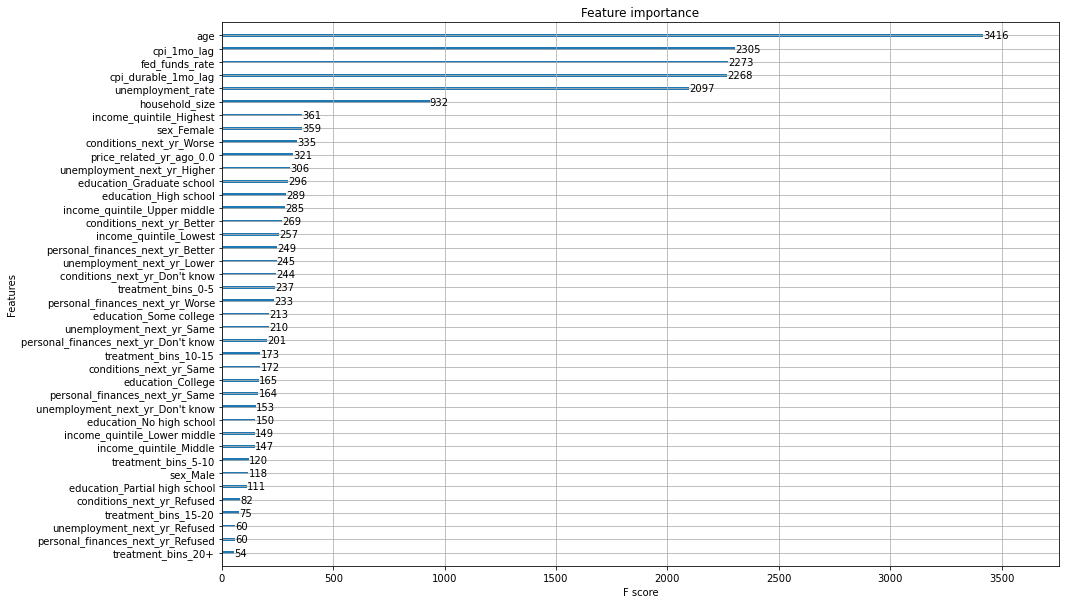

In [30]:
plt.rcParams['figure.figsize'] = [15, 10]
xgb.plot_importance(model2)

In [31]:
data_xgboost, treatment_vars, confounder_vars = prep_features(data,regression=False,missing_values='retain all')  

Excluding 12029 observations that refused or didn't know durable purchase question.
Excluding 16763 observations that did not answer price change amount question.


In [32]:
# try multiple classifiers

data_xgboost = rebin_outcome(data_xgboost)
X = data_xgboost[confounder_vars+treatment_vars]
Y = data_xgboost[['durable_purchase','durable_good','durable_bad']]
Xa, Xb, ya, yb = train_test_split(X, Y, test_size=0.5, random_state=7)  # just switch train and test
ya_good = ya['durable_good']
ya_bad = ya['durable_bad']
yb_good = yb['durable_good']
yb_bad = yb['durable_bad']

model3a = xgb.XGBClassifier(
    learning_rate=0.07,max_depth=4,n_estimators=120,min_child_weight=1,
    eval_metric='logloss',use_label_encoder=False)
model3a.fit(Xa, ya_good)

model3b = xgb.XGBClassifier(
    learning_rate=0.07,max_depth=4,n_estimators=120,min_child_weight=1,
    eval_metric='logloss',use_label_encoder=False)
model3b.fit(Xb, yb_bad)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.07, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=120, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [36]:
ya_pred = model3a.predict(Xb)
yb_pred = model3b.predict(Xa)
print(pd.DataFrame([ya_pred,yb_pred]).T.value_counts().to_dict())
print(yb_good.value_counts(normalize=True))
print(pd.Series(ya_pred).value_counts(normalize=True))
print(ya_bad.value_counts(normalize=True))
print(pd.Series(yb_pred).value_counts(normalize=True))

{(1.0, 0.0): 97091, (0.0, 0.0): 6595, (1.0, 1.0): 5183, (0.0, 1.0): 378}
1    0.73897
0    0.26103
Name: durable_good, dtype: float64
1    0.936173
0    0.063827
dtype: float64
0    0.77506
1    0.22494
Name: durable_bad, dtype: float64
0    0.949097
1    0.050903
dtype: float64


In [38]:
ya_pred = model3a.predict(Xa)
yb_pred = model3b.predict(Xb)
print(pd.DataFrame([ya_pred,yb_pred]).T.value_counts().to_dict())
print(ya_good.value_counts(normalize=True))
print(pd.Series(ya_pred).value_counts(normalize=True))
print(yb_bad.value_counts(normalize=True))
print(pd.Series(yb_pred).value_counts(normalize=True))

{(1.0, 0.0): 97016, (0.0, 0.0): 6681, (1.0, 1.0): 5154, (0.0, 1.0): 396}
1    0.737521
0    0.262479
Name: durable_good, dtype: float64
1    0.93522
0    0.06478
dtype: float64
0    0.775611
1    0.224389
Name: durable_bad, dtype: float64
0    0.949198
1    0.050802
dtype: float64


In [39]:
data_xgboost = rebin_outcome(data_xgboost)
X = data_xgboost[confounder_vars+treatment_vars]
Y = data_xgboost[['durable_purchase','durable_good','durable_bad']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
ya_train = y_train['durable_good']
yb_train = y_train['durable_bad']
ya_test = y_test['durable_good']
yb_test = y_test['durable_bad']

model3a = xgb.XGBClassifier(
    learning_rate=0.07,max_depth=4,n_estimators=120,min_child_weight=1,
    eval_metric='logloss',use_label_encoder=False)
model3a.fit(X_train, np.array(ya_train).astype(int))

model3b = xgb.XGBClassifier(
    learning_rate=0.05,max_depth=5,n_estimators=150,min_child_weight=3,
    eval_metric='logloss',use_label_encoder=False)
model3b.fit(X_train, np.array(yb_train).astype(int))

evaluate_multilevel_predictions(model3a, model3b, X_train, X_test, y_train, y_test)

Baseline accuracy: 73.88%
Train accuracy: 74.46%
Test accuracy: 74.17%

Test predictions vs actual:


actual  predicted
0       -1              37
         0            1247
         1             303
         2            8193
1       -1               1
         0              75
         1              31
         2            1528
2       -1              29
         0             809
         1             314
         2           31132
dtype: int64

***Classification with NN***

In [ ]:
# model 3: large neural network just to see if we can overfit at least
model3 = MLPClassifier(hidden_layer_sizes=(100,100), max_iter=1000)
model3.fit(X_train, y_train)

In [ ]:
num_params = sum([coef.shape[0] * coef.shape[1] for coef in model3.coefs_])
num_params += sum([intercept.shape[0] for intercept in model3.intercepts_])
num_params

15603

In [ ]:
evaluate_predictions(model3, X_train, X_test, y_train, y_test,regression=False)

Baseline accuracy: 71.63%
Train accuracy: 76.52%
Test accuracy: 70.52%

Test predictions vs actual:


actual  predicted
0.0     0             3076
        1              109
        2             9738
1.0     0              307
        1               30
        2             1916
2.0     0             3495
        1              206
        2            34619
dtype: int64

## Helper Functions

In [3]:
# Conditional outcome models (Q models)
def make_Q_model():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return xgb.XGBClassifier()

# Propensity score models (g models)
def make_g_model():
    ''' A function that returns a g model for computing propensity scores'''
    return xgb.XGBClassifier()

In [4]:
# Functions for K-fold cross-fitting
def treatment_k_fold_fit_and_predict(make_model, X:pd.DataFrame, A:np.array, n_splits:int):
    '''
    Implements K fold cross-fitting for the model predicting the treatment A. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns an array containing the predictions  

    Args:
    model: function that returns sklearn model (which implements fit and predict_prob)
    X: dataframe of variables to adjust for
    A: array of treatments
    n_splits: number of splits to use
    '''

    predictions = np.full_like(A, np.nan, dtype=float)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    kf.split(X, A)
    for train_index, test_index in kf.split(X, A):
        X_train = X.iloc[train_index]
        A_train = A.iloc[train_index]
        g = make_model()
        g.fit(X_train, A_train)

        # get predictions for split
        predictions[test_index] = g.predict_proba(X.loc[test_index])[:, 1]
    
    # sanity check that overlap holds
    assert np.isnan(predictions).sum() == 0
    return predictions

def outcome_k_fold_fit_and_predict(make_model, X:pd.DataFrame, y:np.array, A:np.array, n_splits:int, output_type:str):
    '''
    Implements K fold cross-fitting for the model predicting the outcome Y. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns two arrays containing the predictions for all units untreated, all units treated  

    Args:
    model: function that returns sklearn model (that implements fit and either predict_prob or predict)
    X: dataframe of variables to adjust for
    y: array of outcomes
    A: array of treatments
    n_splits: number of splits to use
    output_type: type of outcome, "binary" or "continuous"
    '''

    predictions0 = np.full_like(A, np.nan, dtype=float)
    predictions1 = np.full_like(y, np.nan, dtype=float)
    if output_type == 'binary':
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    elif output_type == 'continuous':
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    # include the treatment as input feature
    X_w_treatment = X.copy()
    X_w_treatment["A"] = A

    # for predicting effect under treatment / control status for each data point 
    X0 = X_w_treatment.copy()
    X0["A"] = 0
    X1 = X_w_treatment.copy()
    X1["A"] = 1
    X2 = X_w_treatment.copy()
    X2["A"] = 2
    X3 = X_w_treatment.copy()
    X3["A"] = 3
    X4 = X_w_treatment.copy()
    X4["A"] = 4

    
    for train_index, test_index in kf.split(X_w_treatment, y):
        X_train = X_w_treatment.loc[train_index]
        y_train = y.loc[train_index]
        q = make_model()
        q.fit(X_train, y_train)

        if output_type =='binary':
            predictions0[test_index] = q.predict_proba(X0.loc[test_index])[:, 1]
            predictions1[test_index] = q.predict_proba(X1.loc[test_index])[:, 1]
        elif output_type == 'continuous':
            predictions0[test_index] = q.predict(X0.loc[test_index])
            predictions1[test_index] = q.predict(X1.loc[test_index])


    assert np.isnan(predictions0).sum() == 0
    assert np.isnan(predictions1).sum() == 0
    return predictions0, predictions1

In [7]:
# Fit Q(X,A) model
# get conditional outcomes
# Q0_lm, Q1_lm = outcome_k_fold_fit_and_predict(make_Q_model, X=confounders, y=outcome, A=treatment, \
#                                         n_splits=5, output_type="continuous")

# Fit g(x) models
g = treatment_k_fold_fit_and_predict(make_g_model, X=data_xgboost[confounder_vars], A=data_xgboost["treatment_bins"], n_splits=5)

KeyError: '[0, 1, 3, 11, 12, 13, 18, 23, 33, 41, 42, 47, 55, 56, 59, 60, 71, 73, 74, 77, 80, 89, 96, 102, 104, 113, 114, 117, 125, 126, 128, 133, 136, 143, 151, 155, 156, 160, 168, 170, 179, 185, 196, 204, 213, 217, 218, 227, 229, 237, 244, 247, 255, 256, 258, 265, 266, 267, 277, 281, 290, 295, 300, 303, 306, 308, 311, 321, 322, 325, 333, 336, 341, 346, 352, 359, 363, 365, 385, 392, 395, 396, 399, 400, 401, 404, 416, 425, 426, 429, 431, 432, 437, 445, 451, 454, 456, 464, 479, 481, 482, 483, 488, 502, 503, 516, 519, 521, 529, 540, 555, 560, 563, 564, 569, 588, 590, 592, 593, 597, 599, 602, 604, 611, 613, 616, 620, 641, 642, 644, 645, 657, 659, 664, 666, 667, 669, 670, 671, 676, 685, 687, 689, 702, 706, 709, 711, 714, 718, 729, 731, 735, 737, 738, 739, 748, 749, 750, 751, 755, 758, 759, 772, 775, 786, 790, 791, 793, 795, 800, 801, 802, 803, 807, 811, 822, 829, 844, 849, 852, 859, 861, 875, 878, 883, 886, 892, 895, 900, 913, 919, 922, 926, 927, 928, 935, 937, 940, 944, 945, 950, 954, 956, 960, 962, 973, 986, 998, 1003, 1012, 1021, 1027, 1029, 1035, 1038, 1039, 1050, 1058, 1062, 1065, 1068, 1078, 1084, 1085, 1103, 1107, 1122, 1127, 1130, 1140, 1147, 1162, 1169, 1178, 1182, 1186, 1191, 1198, 1199, 1203, 1204, 1214, 1218, 1225, 1237, 1243, 1244, 1248, 1257, 1260, 1261, 1263, 1265, 1272, 1274, 1277, 1286, 1291, 1293, 1295, 1297, 1298, 1309, 1310, 1314, 1324, 1330, 1357, 1371, 1374, 1375, 1377, 1378, 1382, 1385, 1388, 1391, 1399, 1400, 1416, 1420, 1425, 1435, 1436, 1437, 1440, 1441, 1447, 1464, 1479, 1491, 1492, 1504, 1510, 1515, 1518, 1521, 1522, 1524, 1537, 1539, 1540, 1545, 1548, 1553, 1560, 1562, 1565, 1593, 1596, 1608, 1609, 1611, 1621, 1624, 1632, 1633, 1655, 1658, 1662, 1663, 1669, 1670, 1675, 1676, 1677, 1681, 1684, 1691, 1699, 1703, 1705, 1711, 1712, 1718, 1719, 1726, 1733, 1734, 1738, 1741, 1742, 1743, 1745, 1751, 1753, 1754, 1755, 1760, 1775, 1781, 1790, 1813, 1819, 1821, 1824, 1830, 1838, 1841, 1842, 1845, 1852, 1854, 1857, 1872, 1873, 1878, 1887, 1889, 1893, 1895, 1899, 1904, 1906, 1910, 1912, 1913, 1914, 1917, 1920, 1928, 1930, 1932, 1936, 1939, 1952, 1972, 1979, 1981, 1985, 1990, 1995, 1996, 1999, 2003, 2006, 2009, 2011, 2013, 2018, 2021, 2030, 2036, 2038, 2039, 2049, 2052, 2053, 2058, 2064, 2071, 2075, 2076, 2088, 2090, 2091, 2097, 2101, 2109, 2114, 2129, 2132, 2148, 2167, 2179, 2181, 2184, 2198, 2213, 2221, 2226, 2230, 2235, 2237, 2239, 2244, 2245, 2252, 2254, 2257, 2258, 2267, 2272, 2273, 2281, 2285, 2293, 2306, 2314, 2326, 2330, 2342, 2347, 2351, 2355, 2357, 2359, 2360, 2361, 2363, 2366, 2368, 2370, 2375, 2376, 2390, 2391, 2392, 2411, 2412, 2415, 2424, 2431, 2432, 2444, 2446, 2449, 2458, 2460, 2462, 2469, 2477, 2484, 2489, 2494, 2496, 2497, 2499, 2508, 2516, 2522, 2534, 2540, 2543, 2551, 2552, 2557, 2560, 2565, 2567, 2568, 2570, 2576, 2577, 2587, 2590, 2595, 2596, 2602, 2612, 2614, 2626, 2641, 2644, 2650, 2651, 2658, 2667, 2669, 2672, 2674, 2676, 2691, 2693, 2697, 2702, 2715, 2720, 2721, 2733, 2736, 2738, 2739, 2740, 2744, 2751, 2760, 2763, 2764, 2767, 2773, 2776, 2781, 2795, 2798, 2804, 2811, 2814, 2818, 2823, 2831, 2833, 2839, 2841, 2858, 2862, 2868, 2870, 2871, 2879, 2882, 2884, 2885, 2890, 2891, 2905, 2917, 2922, 2926, 2936, 2937, 2942, 2945, 2947, 2955, 2957, 2964, 2970, 2984, 2986, 2990, 2995, 2997, 3002, 3008, 3010, 3011, 3015, 3021, 3024, 3027, 3029, 3032, 3034, 3036, 3044, 3047, 3050, 3053, 3070, 3074, 3081, 3084, 3088, 3091, 3093, 3100, 3103, 3109, 3110, 3111, 3120, 3121, 3125, 3128, 3129, 3132, 3134, 3143, 3144, 3154, 3172, 3173, 3181, 3189, 3196, 3198, 3206, 3207, 3208, 3211, 3221, 3225, 3234, 3235, 3239, 3250, 3255, 3258, 3265, 3271, 3280, 3285, 3286, 3291, 3292, 3293, 3302, 3306, 3318, 3323, 3329, 3330, 3334, 3335, 3336, 3345, 3346, 3349, 3355, 3358, 3360, 3366, 3368, 3373, 3379, 3381, 3390, 3395, 3400, 3404, 3406, 3408, 3409, 3412, 3421, 3422, 3438, 3441, 3443, 3450, 3453, 3458, 3466, 3468, 3469, 3477, 3479, 3487, 3490, 3495, 3498, 3503, 3518, 3521, 3522, 3523, 3528, 3535, 3536, 3538, 3540, 3544, 3551, 3554, 3558, 3563, 3564, 3566, 3568, 3572, 3578, 3579, 3587, 3591, 3592, 3597, 3607, 3617, 3624, 3631, 3633, 3634, 3635, 3642, 3646, 3651, 3655, 3662, 3667, 3673, 3678, 3686, 3690, 3701, 3702, 3704, 3705, 3706, 3712, 3715, 3724, 3725, 3730, 3734, 3749, 3750, 3751, 3753, 3761, 3763, 3786, 3787, 3805, 3808, 3809, 3811, 3820, 3827, 3843, 3846, 3850, 3852, 3853, 3868, 3879, 3883, 3884, 3895, 3899, 3907, 3911, 3912, 3916, 3920, 3921, 3925, 3927, 3934, 3942, 3954, 3960, 3964, 3970, 3978, 3984, 4002, 4010, 4012, 4014, 4015, 4018, 4020, 4022, 4025, 4026, 4032, 4035, 4037, 4038, 4050, 4052, 4059, 4068, 4070, 4076, 4081, 4085, 4087, 4089, 4092, 4097, 4101, 4102, 4103, 4115, 4117, 4120, 4124, 4129, 4132, 4133, 4138, 4142, 4143, 4159, 4167, 4170, 4171, 4180, 4204, 4213, 4217, 4218, 4220, 4231, 4239, 4240, 4245, 4247, 4252, 4255, 4260, 4274, 4277, 4278, 4285, 4291, 4299, 4305, 4311, 4316, 4319, 4320, 4322, 4323, 4324, 4328, 4334, 4344, 4346, 4347, 4353, 4355, 4361, 4369, 4370, 4371, 4373, 4381, 4382, 4387, 4393, 4398, 4406, 4408, 4413, 4415, 4416, 4421, 4424, 4426, 4428, 4436, 4437, 4438, 4454, 4457, 4461, 4462, 4471, 4492, 4501, 4504, 4506, 4511, 4522, 4530, 4531, 4533, 4534, 4543, 4551, 4552, 4556, 4558, 4559, 4564, 4567, 4569, 4578, 4598, 4603, 4608, 4611, 4614, 4615, 4626, 4636, 4643, 4651, 4660, 4670, 4671, 4675, 4676, 4677, 4684, 4688, 4693, 4695, 4697, 4698, 4699, 4705, 4708, 4710, 4711, 4713, 4716, 4721, 4729, 4737, 4752, 4771, 4772, 4779, 4781, 4790, 4798, 4799, 4813, 4817, 4826, 4830, 4834, 4836, 4841, 4843, 4846, 4849, 4866, 4886, 4888, 4893, 4900, 4910, 4921, 4932, 4938, 4943, 4948, 4952, 4955, 4959, 4965, 4969, 4972, 4984, 4987, 4999, 5000, 5013, 5024, 5025, 5029, 5031, 5036, 5037, 5038, 5044, 5045, 5058, 5060, 5065, 5074, 5076, 5077, 5091, 5100, 5101, 5109, 5110, 5111, 5114, 5118, 5120, 5128, 5137, 5149, 5154, 5165, 5167, 5169, 5172, 5174, 5181, 5189, 5190, 5195, 5200, 5208, 5215, 5220, 5221, 5235, 5248, 5249, 5251, 5254, 5257, 5258, 5259, 5265, 5277, 5280, 5288, 5291, 5294, 5298, 5307, 5321, 5322, 5325, 5333, 5334, 5337, 5340, 5345, 5348, 5350, 5351, 5359, 5362, 5368, 5372, 5383, 5390, 5394, 5396, 5397, 5399, 5400, 5411, 5418, 5420, 5425, 5427, 5428, 5432, 5433, 5439, 5445, 5450, 5451, 5454, 5457, 5459, 5460, 5461, 5467, 5474, 5477, 5481, 5483, 5492, 5500, 5503, 5509, 5511, 5515, 5523, 5529, 5533, 5534, 5539, 5540, 5548, 5568, 5569, 5576, 5596, 5609, 5617, 5618, 5621, 5625, 5627, 5634, 5639, 5645, 5647, 5649, 5656, 5662, 5667, 5671, 5673, 5677, 5680, 5686, 5688, 5689, 5693, 5694, 5695, 5696, 5698, 5702, 5704, 5707, 5710, 5713, 5718, 5719, 5720, 5723, 5725, 5726, 5728, 5731, 5736, 5738, 5754, 5774, 5775, 5777, 5780, 5781, 5788, 5796, 5805, 5816, 5819, 5829, 5831, 5832, 5835, 5838, 5842, 5843, 5849, 5855, 5857, 5862, 5866, 5878, 5880, 5881, 5893, 5895, 5896, 5910, 5911, 5914, 5921, 5923, 5928, 5929, 5930, 5934, 5940, 5941, 5945, 5946, 5954, 5958, 5960, 5964, 5965, 5969, 5970, 5971, 5979, 5986, 5987, 5988, 5990, 6005, 6006, 6016, 6025, 6030, 6034, 6039, 6041, 6042, 6051, 6054, 6070, 6071, 6076, 6078, 6079, 6090, 6091, 6096, 6107, 6110, 6118, 6125, 6130, 6132, 6134, 6135, 6144, 6158, 6164, 6168, 6174, 6179, 6181, 6185, 6186, 6199, 6202, 6213, 6218, 6220, 6224, 6240, 6243, 6247, 6255, 6256, 6262, 6274, 6280, 6284, 6285, 6286, 6287, 6288, 6289, 6291, 6295, 6297, 6299, 6303, 6304, 6305, 6307, 6316, 6322, 6323, 6329, 6332, 6333, 6336, 6337, 6340, 6344, 6346, 6350, 6352, 6358, 6371, 6372, 6375, 6377, 6379, 6386, 6387, 6400, 6408, 6410, 6414, 6417, 6426, 6427, 6431, 6432, 6433, 6436, 6441, 6445, 6452, 6456, 6459, 6461, 6463, 6465, 6471, 6474, 6475, 6477, 6479, 6486, 6488, 6492, 6496, 6497, 6503, 6505, 6508, 6511, 6519, 6520, 6529, 6538, 6540, 6543, 6544, 6545, 6555, 6560, 6572, 6576, 6578, 6583, 6589, 6594, 6601, 6605, 6609, 6610, 6611, 6617, 6621, 6628, 6629, 6636, 6640, 6643, 6645, 6646, 6648, 6653, 6656, 6659, 6662, 6675, 6687, 6690, 6692, 6694, 6698, 6704, 6705, 6708, 6711, 6716, 6721, 6722, 6724, 6730, 6738, 6740, 6762, 6764, 6765, 6766, 6773, 6775, 6777, 6780, 6784, 6785, 6796, 6800, 6812, 6815, 6816, 6819, 6824, 6834, 6842, 6847, 6850, 6851, 6855, 6860, 6866, 6867, 6875, 6884, 6885, 6894, 6895, 6896, 6897, 6899, 6900, 6909, 6912, 6917, 6919, 6920, 6924, 6925, 6928, 6931, 6940, 6946, 6952, 6955, 6959, 6962, 6964, 6965, 6972, 6976, 6978, 6980, 6985, 6998, 7000, 7011, 7012, 7016, 7047, 7048, 7051, 7058, 7064, 7066, 7070, 7074, 7076, 7081, 7084, 7100, 7113, 7117, 7121, 7122, 7142, 7144, 7146, 7147, 7153, 7159, 7160, 7162, 7164, 7166, 7182, 7190, 7202, 7204, 7215, 7220, 7229, 7233, 7235, 7239, 7254, 7278, 7280, 7281, 7285, 7293, 7294, 7296, 7298, 7299, 7301, 7304, 7306, 7310, 7321, 7323, 7325, 7331, 7333, 7343, 7346, 7348, 7367, 7374, 7378, 7379, 7381, 7387, 7390, 7393, 7394, 7404, 7406, 7412, 7414, 7422, 7433, 7436, 7443, 7445, 7446, 7457, 7459, 7460, 7469, 7476, 7491, 7523, 7530, 7546, 7547, 7549, 7555, 7564, 7565, 7582, 7583, 7586, 7587, 7589, 7594, 7602, 7607, 7612, 7618, 7620, 7624, 7627, 7631, 7635, 7644, 7645, 7658, 7659, 7660, 7676, 7679, 7681, 7684, 7690, 7691, 7696, 7698, 7701, 7703, 7710, 7713, 7718, 7723, 7724, 7727, 7728, 7735, 7739, 7742, 7747, 7748, 7749, 7757, 7764, 7773, 7784, 7785, 7788, 7797, 7799, 7810, 7817, 7826, 7831, 7838, 7840, 7844, 7846, 7850, 7852, 7856, 7861, 7862, 7865, 7867, 7876, 7877, 7879, 7881, 7886, 7892, 7899, 7906, 7909, 7910, 7914, 7926, 7937, 7938, 7939, 7942, 7945, 7946, 7948, 7955, 7962, 7971, 7980, 7993, 7995, 7996, 8001, 8002, 8005, 8026, 8028, 8037, 8039, 8040, 8045, 8049, 8051, 8058, 8076, 8077, 8081, 8084, 8086, 8097, 8099, 8100, 8105, 8107, 8108, 8115, 8117, 8120, 8121, 8131, 8132, 8138, 8155, 8157, 8162, 8178, 8180, 8185, 8186, 8188, 8190, 8195, 8204, 8217, 8218, 8220, 8223, 8225, 8226, 8232, 8235, 8239, 8245, 8246, 8251, 8252, 8254, 8259, 8262, 8268, 8270, 8272, 8273, 8277, 8279, 8280, 8281, 8287, 8303, 8326, 8328, 8341, 8343, 8345, 8348, 8350, 8356, 8359, 8363, 8368, 8370, 8375, 8380, 8383, 8384, 8408, 8409, 8410, 8413, 8414, 8415, 8420, 8433, 8438, 8440, 8442, 8448, 8452, 8459, 8460, 8464, 8467, 8471, 8474, 8475, 8485, 8488, 8501, 8506, 8511, 8527, 8528, 8544, 8550, 8551, 8563, 8564, 8575, 8577, 8581, 8591, 8613, 8616, 8618, 8630, 8631, 8634, 8639, 8646, 8662, 8663, 8664, 8669, 8670, 8676, 8677, 8680, 8692, 8693, 8700, 8722, 8723, 8724, 8725, 8728, 8731, 8739, 8741, 8742, 8743, 8752, 8761, 8764, 8768, 8777, 8783, 8792, 8799, 8801, 8802, 8803, 8809, 8818, 8827, 8830, 8833, 8834, 8837, 8842, 8844, 8848, 8851, 8854, 8861, 8862, 8865, 8868, 8873, 8876, 8878, 8885, 8891, 8892, 8917, 8921, 8922, 8923, 8928, 8931, 8932, 8934, 8936, 8937, 8943, 8944, 8946, 8968, 8978, 8987, 8991, 8992, 8993, 9001, 9004, 9007, 9013, 9018, 9022, 9029, 9033, 9045, 9053, 9054, 9055, 9062, 9065, 9076, 9083, 9084, 9089, 9097, 9101, 9105, 9118, 9128, 9142, 9153, 9154, 9168, 9169, 9175, 9181, 9187, 9189, 9197, 9203, 9204, 9205, 9207, 9210, 9231, 9236, 9239, 9248, 9251, 9255, 9257, 9267, 9269, 9272, 9273, 9275, 9276, 9279, 9280, 9292, 9302, 9306, 9309, 9310, 9313, 9315, 9322, 9323, 9331, 9341, 9350, 9353, 9369, 9374, 9376, 9378, 9384, 9385, 9390, 9392, 9401, 9403, 9404, 9406, 9410, 9412, 9416, 9424, 9427, 9434, 9439, 9444, 9449, 9464, 9470, 9473, 9475, 9488, 9497, 9506, 9515, 9519, 9522, 9526, 9542, 9560, 9565, 9569, 9572, 9576, 9592, 9597, 9598, 9601, 9604, 9621, 9623, 9624, 9630, 9639, 9646, 9650, 9652, 9655, 9659, 9660, 9683, 9690, 9694, 9697, 9704, 9713, 9714, 9726, 9727, 9729, 9732, 9740, 9742, 9755, 9756, 9765, 9767, 9771, 9773, 9775, 9779, 9784, 9786, 9794, 9797, 9808, 9809, 9816, 9818, 9820, 9822, 9823, 9825, 9837, 9838, 9839, 9840, 9850, 9853, 9858, 9862, 9864, 9871, 9874, 9881, 9895, 9896, 9899, 9901, 9920, 9924, 9931, 9940, 9942, 9948, 9970, 9971, 9975, 9977, 9983, 9991, 9995, 9999, 10000, 10007, 10011, 10024, 10027, 10028, 10049, 10050, 10056, 10062, 10064, 10066, 10068, 10076, 10077, 10082, 10086, 10096, 10099, 10101, 10102, 10107, 10116, 10121, 10126, 10128, 10130, 10134, 10136, 10141, 10148, 10150, 10153, 10162, 10170, 10172, 10175, 10178, 10184, 10186, 10195, 10203, 10205, 10207, 10213, 10217, 10221, 10222, 10227, 10230, 10232, 10234, 10237, 10238, 10245, 10246, 10250, 10256, 10260, 10261, 10263, 10265, 10267, 10273, 10281, 10283, 10286, 10289, 10291, 10301, 10303, 10304, 10307, 10310, 10313, 10319, 10322, 10326, 10327, 10339, 10345, 10350, 10352, 10355, 10359, 10373, 10389, 10392, 10394, 10395, 10397, 10402, 10410, 10414, 10419, 10423, 10430, 10432, 10440, 10442, 10443, 10454, 10456, 10471, 10475, 10479, 10486, 10488, 10490, 10492, 10508, 10509, 10511, 10516, 10517, 10519, 10522, 10528, 10530, 10533, 10538, 10542, 10545, 10546, 10548, 10561, 10576, 10579, 10583, 10585, 10589, 10591, 10595, 10603, 10605, 10607, 10609, 10615, 10619, 10626, 10628, 10651, 10654, 10662, 10664, 10671, 10673, 10675, 10681, 10686, 10689, 10699, 10701, 10707, 10708, 10715, 10726, 10729, 10734, 10750, 10751, 10756, 10774, 10775, 10781, 10782, 10784, 10785, 10789, 10798, 10803, 10807, 10808, 10811, 10813, 10816, 10824, 10827, 10829, 10830, 10836, 10845, 10846, 10860, 10862, 10868, 10874, 10884, 10890, 10899, 10903, 10904, 10905, 10908, 10911, 10928, 10932, 10938, 10939, 10941, 10944, 10950, 10952, 10953, 10955, 10959, 10961, 10962, 10965, 10968, 10969, 10987, 10988, 10991, 11004, 11008, 11013, 11020, 11024, 11026, 11029, 11032, 11042, 11043, 11050, 11074, 11080, 11081, 11096, 11097, 11104, 11106, 11123, 11125, 11135, 11139, 11151, 11167, 11173, 11174, 11178, 11181, 11183, 11186, 11188, 11190, 11193, 11197, 11202, 11209, 11210, 11214, 11229, 11234, 11247, 11250, 11251, 11253, 11255, 11264, 11270, 11279, 11280, 11289, 11293, 11305, 11311, 11314, 11317, 11318, 11319, 11323, 11324, 11331, 11336, 11337, 11345, 11347, 11354, 11355, 11363, 11377, 11378, 11380, 11381, 11393, 11394, 11398, 11402, 11407, 11409, 11412, 11421, 11423, 11424, 11425, 11431, 11439, 11444, 11447, 11455, 11457, 11464, 11465, 11467, 11472, 11476, 11482, 11485, 11492, 11507, 11510, 11511, 11515, 11519, 11520, 11526, 11531, 11542, 11548, 11551, 11557, 11559, 11562, 11565, 11566, 11569, 11571, 11573, 11574, 11576, 11577, 11589, 11593, 11595, 11597, 11601, 11612, 11620, 11621, 11622, 11624, 11626, 11628, 11635, 11637, 11639, 11640, 11645, 11647, 11652, 11654, 11656, 11669, 11673, 11675, 11681, 11693, 11701, 11705, 11706, 11713, 11714, 11717, 11720, 11722, 11729, 11730, 11732, 11734, 11736, 11737, 11738, 11744, 11746, 11750, 11754, 11756, 11760, 11762, 11781, 11792, 11798, 11804, 11811, 11815, 11817, 11821, 11822, 11825, 11828, 11832, 11841, 11846, 11850, 11862, 11873, 11874, 11877, 11879, 11882, 11887, 11888, 11892, 11893, 11895, 11901, 11911, 11912, 11913, 11921, 11931, 11937, 11940, 11943, 11950, 11952, 11954, 11960, 11962, 11969, 11972, 11977, 11983, 11984, 11993, 11994, 11997, 12006, 12007, 12008, 12009, 12014, 12019, 12022, 12031, 12032, 12035, 12036, 12047, 12049, 12050, 12054, 12056, 12058, 12059, 12060, 12065, 12067, 12068, 12080, 12081, 12089, 12090, 12092, 12093, 12099, 12113, 12130, 12139, 12146, 12150, 12151, 12152, 12153, 12154, 12163, 12166, 12175, 12178, 12189, 12191, 12192, 12193, 12210, 12213, 12218, 12222, 12226, 12237, 12251, 12255, 12264, 12265, 12273, 12277, 12284, 12298, 12299, 12300, 12302, 12308, 12309, 12310, 12324, 12329, 12332, 12337, 12343, 12349, 12350, 12351, 12362, 12367, 12371, 12374, 12376, 12378, 12381, 12384, 12409, 12411, 12413, 12416, 12417, 12429, 12432, 12438, 12439, 12444, 12455, 12457, 12465, 12469, 12476, 12478, 12480, 12483, 12491, 12492, 12502, 12503, 12509, 12512, 12516, 12519, 12521, 12525, 12527, 12543, 12555, 12565, 12566, 12569, 12571, 12577, 12579, 12582, 12585, 12589, 12597, 12598, 12599, 12606, 12607, 12612, 12618, 12620, 12624, 12628, 12632, 12644, 12646, 12647, 12649, 12650, 12665, 12672, 12682, 12684, 12691, 12701, 12710, 12713, 12718, 12719, 12721, 12725, 12726, 12727, 12728, 12729, 12732, 12734, 12739, 12749, 12758, 12768, 12769, 12773, 12774, 12778, 12786, 12789, 12790, 12793, 12802, 12803, 12806, 12809, 12819, 12820, 12823, 12824, 12826, 12834, 12835, 12838, 12845, 12857, 12861, 12868, 12870, 12871, 12873, 12875, 12876, 12879, 12881, 12886, 12890, 12894, 12913, 12941, 12943, 12945, 12953, 12956, 12977, 12979, 12980, 12984, 12988, 12989, 12990, 12992, 12994, 12996, 13001, 13007, 13010, 13017, 13032, 13036, 13051, 13056, 13067, 13088, 13091, 13092, 13093, 13100, 13103, 13119, 13122, 13127, 13129, 13133, 13142, 13161, 13164, 13169, 13171, 13175, 13180, 13181, 13188, 13189, 13190, 13194, 13203, 13226, 13240, 13242, 13259, 13260, 13262, 13264, 13269, 13272, 13274, 13275, 13276, 13279, 13284, 13288, 13294, 13302, 13303, 13309, 13313, 13319, 13320, 13328, 13330, 13332, 13333, 13335, 13337, 13346, 13356, 13358, 13367, 13368, 13375, 13383, 13391, 13404, 13409, 13410, 13414, 13418, 13423, 13426, 13435, 13439, 13450, 13456, 13458, 13460, 13462, 13464, 13465, 13466, 13470, 13472, 13481, 13482, 13485, 13487, 13495, 13500, 13505, 13510, 13518, 13521, 13535, 13537, 13539, 13540, 13543, 13559, 13563, 13564, 13565, 13570, 13571, 13578, 13579, 13580, 13582, 13585, 13586, 13588, 13596, 13602, 13604, 13614, 13616, 13622, 13624, 13635, 13639, 13644, 13645, 13648, 13656, 13658, 13663, 13668, 13671, 13677, 13678, 13694, 13702, 13705, 13706, 13710, 13712, 13713, 13727, 13747, 13753, 13754, 13757, 13761, 13780, 13782, 13785, 13794, 13795, 13800, 13807, 13821, 13834, 13847, 13858, 13881, 13884, 13896, 13899, 13907, 13911, 13918, 13921, 13934, 13935, 13938, 13941, 13943, 13949, 13953, 13961, 13977, 14006, 14007, 14011, 14020, 14025, 14035, 14038, 14050, 14055, 14066, 14071, 14073, 14075, 14083, 14088, 14111, 14122, 14123, 14143, 14147, 14149, 14150, 14172, 14174, 14176, 14186, 14193, 14194, 14200, 14205, 14208, 14213, 14215, 14216, 14217, 14218, 14226, 14227, 14228, 14234, 14249, 14261, 14263, 14264, 14268, 14270, 14274, 14277, 14285, 14286, 14291, 14294, 14300, 14307, 14322, 14333, 14340, 14349, 14355, 14361, 14362, 14363, 14367, 14375, 14378, 14387, 14395, 14399, 14400, 14408, 14428, 14434, 14437, 14446, 14451, 14456, 14457, 14464, 14486, 14488, 14491, 14496, 14498, 14505, 14516, 14522, 14532, 14536, 14537, 14541, 14542, 14550, 14552, 14561, 14563, 14566, 14567, 14568, 14570, 14573, 14576, 14590, 14601, 14604, 14610, 14617, 14620, 14621, 14626, 14630, 14635, 14636, 14640, 14648, 14649, 14666, 14673, 14674, 14675, 14683, 14685, 14687, 14703, 14705, 14706, 14712, 14721, 14731, 14734, 14740, 14743, 14747, 14754, 14758, 14762, 14763, 14771, 14772, 14777, 14785, 14789, 14791, 14803, 14807, 14809, 14812, 14844, 14846, 14851, 14857, 14873, 14880, 14891, 14895, 14902, 14904, 14929, 14930, 14931, 14932, 14935, 14936, 14938, 14939, 14941, 14942, 14960, 14967, 14969, 14972, 14974, 14982, 14989, 14994, 15008, 15011, 15013, 15019, 15035, 15047, 15049, 15051, 15056, 15058, 15070, 15075, 15076, 15080, 15087, 15095, 15097, 15099, 15100, 15101, 15102, 15107, 15109, 15115, 15129, 15130, 15135, 15141, 15143, 15147, 15148, 15154, 15157, 15161, 15167, 15175, 15176, 15185, 15189, 15191, 15194, 15195, 15196, 15201, 15203, 15213, 15222, 15226, 15231, 15234, 15235, 15236, 15239, 15246, 15263, 15271, 15274, 15286, 15287, 15291, 15292, 15293, 15303, 15307, 15312, 15316, 15322, 15325, 15331, 15333, 15336, 15337, 15347, 15349, 15350, 15352, 15353, 15354, 15355, 15357, 15362, 15368, 15371, 15374, 15378, 15380, 15390, 15393, 15400, 15406, 15408, 15409, 15413, 15419, 15424, 15431, 15435, 15437, 15441, 15449, 15465, 15477, 15483, 15485, 15489, 15491, 15492, 15497, 15500, 15503, 15505, 15509, 15512, 15513, 15521, 15531, 15532, 15536, 15538, 15543, 15550, 15553, 15554, 15564, 15565, 15566, 15568, 15569, 15570, 15572, 15579, 15581, 15583, 15584, 15585, 15590, 15594, 15599, 15601, 15604, 15605, 15611, 15612, 15616, 15617, 15620, 15623, 15636, 15638, 15642, 15643, 15654, 15655, 15657, 15663, 15667, 15671, 15674, 15676, 15678, 15682, 15683, 15686, 15703, 15705, 15711, 15718, 15735, 15739, 15747, 15748, 15753, 15763, 15765, 15775, 15780, 15781, 15785, 15787, 15790, 15797, 15799, 15800, 15803, 15832, 15838, 15840, 15841, 15843, 15847, 15852, 15853, 15854, 15857, 15860, 15862, 15867, 15869, 15871, 15909, 15912, 15924, 15925, 15938, 15940, 15941, 15943, 15946, 15948, 15951, 15959, 15961, 15964, 15969, 15979, 15980, 15982, 15984, 15990, 15996, 16008, 16017, 16019, 16029, 16030, 16043, 16044, 16052, 16056, 16074, 16078, 16081, 16091, 16096, 16103, 16105, 16106, 16108, 16115, 16117, 16118, 16127, 16133, 16140, 16159, 16171, 16180, 16181, 16183, 16198, 16202, 16215, 16216, 16217, 16218, 16229, 16238, 16240, 16248, 16253, 16263, 16269, 16287, 16292, 16294, 16295, 16298, 16300, 16301, 16302, 16303, 16304, 16310, 16324, 16329, 16340, 16342, 16346, 16350, 16351, 16364, 16370, 16372, 16375, 16378, 16391, 16393, 16401, 16404, 16405, 16407, 16415, 16421, 16424, 16444, 16445, 16450, 16451, 16462, 16465, 16468, 16478, 16483, 16492, 16498, 16503, 16510, 16511, 16518, 16523, 16527, 16529, 16530, 16539, 16541, 16542, 16543, 16544, 16546, 16552, 16561, 16563, 16565, 16568, 16582, 16583, 16585, 16588, 16600, 16604, 16611, 16612, 16613, 16614, 16615, 16620, 16623, 16624, 16628, 16639, 16642, 16643, 16644, 16657, 16662, 16666, 16667, 16670, 16676, 16679, 16684, 16685, 16691, 16692, 16698, 16701, 16711, 16717, 16720, 16722, 16724, 16726, 16751, 16752, 16755, 16760, 16763, 16765, 16767, 16770, 16775, 16786, 16789, 16817, 16823, 16828, 16829, 16832, 16835, 16841, 16846, 16852, 16862, 16868, 16878, 16888, 16891, 16892, 16899, 16901, 16903, 16905, 16908, 16913, 16916, 16919, 16923, 16931, 16936, 16939, 16942, 16954, 16958, 16962, 16966, 16967, 16972, 16975, 16978, 16987, 16988, 17004, 17005, 17008, 17015, 17023, 17028, 17034, 17041, 17047, 17051, 17052, 17064, 17065, 17066, 17069, 17073, 17075, 17079, 17087, 17095, 17096, 17105, 17107, 17109, 17110, 17112, 17114, 17115, 17118, 17119, 17120, 17141, 17152, 17153, 17154, 17158, 17159, 17171, 17181, 17185, 17186, 17192, 17196, 17198, 17201, 17203, 17206, 17208, 17226, 17227, 17228, 17231, 17236, 17239, 17241, 17242, 17244, 17248, 17249, 17250, 17252, 17256, 17257, 17267, 17273, 17276, 17277, 17278, 17283, 17287, 17301, 17302, 17303, 17308, 17314, 17322, 17324, 17326, 17349, 17357, 17358, 17366, 17367, 17370, 17371, 17375, 17390, 17392, 17396, 17397, 17402, 17407, 17409, 17411, 17418, 17431, 17440, 17442, 17444, 17448, 17452, 17454, 17460, 17465, 17466, 17468, 17472, 17481, 17488, 17500, 17506, 17509, 17510, 17511, 17514, 17519, 17540, 17542, 17564, 17566, 17571, 17576, 17587, 17592, 17597, 17598, 17600, 17601, 17602, 17614, 17619, 17623, 17626, 17630, 17640, 17645, 17647, 17654, 17661, 17665, 17666, 17672, 17676, 17702, 17706, 17712, 17715, 17717, 17725, 17726, 17735, 17738, 17741, 17742, 17744, 17747, 17752, 17758, 17759, 17761, 17763, 17767, 17768, 17778, 17781, 17792, 17793, 17795, 17796, 17801, 17803, 17807, 17808, 17809, 17811, 17817, 17824, 17829, 17831, 17833, 17834, 17836, 17846, 17854, 17859, 17860, 17861, 17862, 17875, 17876, 17877, 17888, 17890, 17898, 17903, 17909, 17910, 17911, 17913, 17914, 17922, 17926, 17931, 17934, 17942, 17975, 17982, 17983, 17988, 17990, 17993, 17997, 17999, 18007, 18010, 18012, 18015, 18017, 18019, 18021, 18027, 18030, 18034, 18037, 18038, 18045, 18064, 18069, 18078, 18079, 18080, 18090, 18097, 18098, 18106, 18107, 18118, 18132, 18140, 18143, 18146, 18151, 18156, 18164, 18169, 18170, 18178, 18216, 18218, 18226, 18231, 18239, 18244, 18248, 18249, 18251, 18252, 18260, 18265, 18266, 18272, 18279, 18280, 18288, 18291, 18301, 18302, 18310, 18311, 18314, 18318, 18320, 18326, 18328, 18334, 18339, 18344, 18346, 18350, 18351, 18352, 18355, 18358, 18370, 18376, 18379, 18385, 18386, 18393, 18396, 18398, 18399, 18411, 18413, 18421, 18424, 18434, 18435, 18436, 18437, 18439, 18451, 18459, 18474, 18475, 18478, 18490, 18509, 18512, 18515, 18517, 18520, 18524, 18526, 18533, 18539, 18540, 18543, 18544, 18548, 18550, 18552, 18559, 18573, 18575, 18586, 18601, 18606, 18612, 18616, 18627, 18634, 18636, 18648, 18653, 18661, 18662, 18664, 18671, 18684, 18696, 18704, 18706, 18707, 18725, 18726, 18733, 18739, 18745, 18748, 18753, 18757, 18761, 18766, 18777, 18786, 18787, 18797, 18805, 18808, 18819, 18826, 18828, 18831, 18836, 18851, 18857, 18860, 18862, 18863, 18874, 18899, 18907, 18908, 18910, 18920, 18924, 18927, 18928, 18929, 18932, 18940, 18945, 18950, 18964, 18969, 18970, 18977, 18981, 18985, 18999, 19005, 19019, 19022, 19023, 19025, 19030, 19034, 19046, 19047, 19062, 19063, 19065, 19078, 19080, 19083, 19084, 19085, 19086, 19089, 19093, 19100, 19104, 19110, 19111, 19114, 19115, 19118, 19125, 19128, 19132, 19156, 19159, 19164, 19167, 19168, 19183, 19185, 19188, 19191, 19192, 19199, 19200, 19206, 19209, 19212, 19215, 19220, 19229, 19231, 19233, 19234, 19235, 19238, 19249, 19251, 19261, 19273, 19279, 19280, 19283, 19284, 19287, 19311, 19313, 19315, 19320, 19330, 19347, 19348, 19373, 19379, 19390, 19391, 19394, 19396, 19407, 19408, 19411, 19412, 19418, 19422, 19425, 19434, 19437, 19439, 19441, 19449, 19451, 19457, 19464, 19480, 19486, 19490, 19497, 19500, 19501, 19509, 19512, 19513, 19517, 19526, 19553, 19557, 19566, 19568, 19569, 19572, 19575, 19578, 19580, 19599, 19600, 19603, 19608, 19612, 19615, 19618, 19624, 19626, 19627, 19634, 19639, 19647, 19657, 19658, 19663, 19664, 19677, 19678, 19690, 19692, 19697, 19698, 19704, 19705, 19707, 19710, 19711, 19713, 19727, 19729, 19743, 19744, 19745, 19748, 19752, 19759, 19763, 19765, 19768, 19779, 19784, 19787, 19796, 19800, 19801, 19811, 19812, 19818, 19830, 19840, 19844, 19846, 19852, 19853, 19861, 19867, 19871, 19874, 19877, 19887, 19889, 19895, 19897, 19900, 19919, 19930, 19935, 19946, 19950, 19951, 19954, 19971, 19980, 19987, 19988, 19996, 20013, 20014, 20027, 20029, 20049, 20052, 20054, 20061, 20062, 20063, 20064, 20072, 20074, 20075, 20080, 20081, 20089, 20091, 20100, 20101, 20103, 20104, 20105, 20107, 20109, 20111, 20117, 20134, 20137, 20140, 20145, 20147, 20158, 20159, 20160, 20161, 20166, 20169, 20172, 20173, 20177, 20183, 20184, 20195, 20196, 20203, 20205, 20213, 20214, 20215, 20216, 20218, 20220, 20222, 20223, 20227, 20228, 20229, 20241, 20245, 20246, 20252, 20258, 20259, 20262, 20265, 20267, 20276, 20278, 20280, 20286, 20290, 20294, 20302, 20317, 20326, 20330, 20336, 20342, 20345, 20354, 20357, 20361, 20365, 20374, 20388, 20391, 20397, 20399, 20402, 20408, 20410, 20416, 20423, 20429, 20430, 20432, 20440, 20441, 20447, 20460, 20468, 20469, 20470, 20473, 20487, 20493, 20494, 20499, 20502, 20505, 20506, 20507, 20513, 20514, 20516, 20524, 20525, 20526, 20534, 20535, 20540, 20543, 20555, 20557, 20565, 20567, 20577, 20580, 20583, 20586, 20588, 20593, 20595, 20601, 20603, 20604, 20611, 20618, 20620, 20624, 20629, 20632, 20638, 20659, 20661, 20665, 20666, 20671, 20672, 20676, 20677, 20699, 20702, 20704, 20712, 20714, 20716, 20718, 20730, 20733, 20735, 20743, 20751, 20754, 20760, 20776, 20781, 20782, 20785, 20794, 20795, 20796, 20803, 20806, 20809, 20817, 20824, 20831, 20833, 20835, 20840, 20842, 20846, 20851, 20855, 20859, 20861, 20868, 20870, 20875, 20876, 20878, 20881, 20882, 20885, 20896, 20901, 20904, 20905, 20906, 20908, 20924, 20927, 20935, 20936, 20943, 20947, 20952, 20954, 20963, 20966, 20968, 20973, 20974, 20982, 20984, 20990, 20997, 21008, 21021, 21029, 21031, 21041, 21045, 21046, 21057, 21058, 21074, 21075, 21078, 21080, 21089, 21096, 21098, 21101, 21102, 21104, 21106, 21109, 21110, 21116, 21118, 21133, 21151, 21152, 21155, 21159, 21160, 21170, 21171, 21177, 21200, 21201, 21210, 21215, 21217, 21221, 21222, 21223, 21225, 21226, 21229, 21234, 21237, 21238, 21239, 21242, 21244, 21246, 21251, 21255, 21264, 21269, 21270, 21271, 21276, 21277, 21283, 21285, 21289, 21292, 21294, 21302, 21315, 21320, 21335, 21336, 21337, 21350, 21354, 21360, 21364, 21368, 21371, 21374, 21375, 21381, 21386, 21387, 21388, 21397, 21398, 21399, 21402, 21410, 21418, 21426, 21428, 21433, 21439, 21443, 21465, 21467, 21470, 21479, 21482, 21487, 21502, 21509, 21517, 21532, 21538, 21543, 21545, 21554, 21555, 21559, 21560, 21561, 21564, 21574, 21575, 21578, 21582, 21589, 21592, 21593, 21594, 21601, 21610, 21612, 21615, 21622, 21627, 21631, 21638, 21651, 21652, 21657, 21659, 21667, 21669, 21670, 21674, 21681, 21684, 21696, 21704, 21707, 21709, 21717, 21719, 21722, 21723, 21724, 21741, 21757, 21759, 21764, 21775, 21778, 21784, 21789, 21805, 21807, 21809, 21817, 21818, 21819, 21821, 21826, 21827, 21833, 21834, 21839, 21847, 21850, 21854, 21855, 21864, 21867, 21876, 21884, 21889, 21898, 21908, 21909, 21922, 21926, 21932, 21937, 21940, 21956, 21964, 21965, 21975, 21976, 21977, 21979, 21982, 21983, 22002, 22008, 22009, 22021, 22022, 22025, 22028, 22030, 22033, 22035, 22037, 22041, 22042, 22046, 22061, 22064, 22069, 22070, 22079, 22081, 22092, 22094, 22098, 22106, 22117, 22119, 22120, 22124, 22126, 22128, 22131, 22134, 22135, 22142, 22150, 22154, 22160, 22162, 22166, 22170, 22179, 22181, 22182, 22187, 22195, 22208, 22210, 22212, 22218, 22238, 22244, 22246, 22254, 22267, 22287, 22296, 22297, 22303, 22306, 22321, 22326, 22327, 22336, 22337, 22339, 22344, 22346, 22347, 22355, 22363, 22366, 22373, 22379, 22384, 22390, 22392, 22399, 22410, 22411, 22417, 22425, 22426, 22436, 22445, 22452, 22456, 22461, 22466, 22471, 22479, 22483, 22484, 22489, 22490, 22511, 22512, 22515, 22518, 22525, 22527, 22531, 22537, 22545, 22546, 22547, 22548, 22550, 22554, 22562, 22565, 22578, 22586, 22588, 22593, 22594, 22597, 22600, 22610, 22616, 22620, 22625, 22629, 22630, 22634, 22636, 22640, 22645, 22647, 22650, 22651, 22653, 22658, 22660, 22667, 22671, 22684, 22687, 22693, 22697, 22708, 22712, 22717, 22718, 22720, 22724, 22729, 22730, 22733, 22734, 22744, 22745, 22749, 22752, 22754, 22755, 22756, 22765, 22771, 22775, 22780, 22782, 22789, 22790, 22794, 22795, 22796, 22798, 22802, 22804, 22806, 22810, 22827, 22835, 22840, 22847, 22853, 22865, 22866, 22867, 22870, 22875, 22876, 22877, 22881, 22882, 22883, 22886, 22889, 22896, 22898, 22906, 22908, 22912, 22914, 22917, 22919, 22921, 22923, 22925, 22929, 22930, 22932, 22934, 22938, 22940, 22955, 22959, 22967, 22973, 22977, 22986, 22989, 22990, 22992, 22993, 22996, 23000, 23003, 23005, 23020, 23027, 23029, 23034, 23035, 23044, 23051, 23055, 23059, 23060, 23062, 23065, 23068, 23079, 23080, 23082, 23083, 23090, 23091, 23096, 23098, 23103, 23117, 23121, 23129, 23130, 23137, 23141, 23151, 23152, 23158, 23161, 23172, 23181, 23184, 23189, 23190, 23198, 23202, 23207, 23211, 23219, 23220, 23231, 23234, 23240, 23249, 23261, 23262, 23270, 23272, 23275, 23288, 23291, 23299, 23302, 23304, 23313, 23317, 23323, 23330, 23333, 23334, 23337, 23343, 23344, 23347, 23352, 23356, 23364, 23367, 23380, 23386, 23393, 23395, 23396, 23405, 23406, 23410, 23415, 23416, 23420, 23425, 23429, 23436, 23440, 23442, 23443, 23446, 23456, 23476, 23478, 23484, 23498, 23499, 23501, 23502, 23503, 23504, 23509, 23516, 23520, 23525, 23526, 23527, 23531, 23533, 23542, 23549, 23550, 23551, 23552, 23561, 23562, 23563, 23570, 23574, 23577, 23591, 23595, 23597, 23611, 23615, 23618, 23622, 23629, 23633, 23636, 23646, 23651, 23654, 23667, 23670, 23673, 23674, 23675, 23688, 23689, 23694, 23700, 23705, 23713, 23714, 23715, 23721, 23722, 23723, 23725, 23726, 23728, 23737, 23742, 23743, 23744, 23751, 23754, 23755, 23758, 23761, 23763, 23764, 23772, 23775, 23779, 23780, 23786, 23788, 23798, 23801, 23802, 23811, 23813, 23817, 23822, 23823, 23825, 23829, 23831, 23840, 23843, 23846, 23850, 23859, 23873, 23875, 23878, 23879, 23880, 23887, 23892, 23894, 23901, 23903, 23904, 23915, 23918, 23919, 23920, 23926, 23935, 23937, 23941, 23943, 23951, 23958, 23964, 23965, 23971, 23977, 23985, 23992, 23993, 24009, 24021, 24024, 24029, 24034, 24035, 24036, 24049, 24051, 24055, 24057, 24061, 24069, 24070, 24081, 24082, 24084, 24085, 24086, 24087, 24092, 24095, 24097, 24098, 24101, 24103, 24105, 24108, 24114, 24116, 24122, 24127, 24130, 24131, 24132, 24138, 24149, 24152, 24159, 24165, 24167, 24176, 24179, 24185, 24188, 24194, 24197, 24198, 24200, 24202, 24205, 24206, 24211, 24218, 24228, 24229, 24230, 24236, 24241, 24247, 24249, 24251, 24261, 24270, 24273, 24274, 24278, 24279, 24285, 24287, 24290, 24292, 24294, 24296, 24303, 24307, 24313, 24315, 24325, 24335, 24336, 24343, 24345, 24346, 24351, 24352, 24355, 24361, 24364, 24375, 24376, 24379, 24398, 24402, 24407, 24413, 24423, 24424, 24428, 24435, 24437, 24440, 24444, 24445, 24452, 24455, 24458, 24461, 24465, 24466, 24467, 24475, 24485, 24496, 24497, 24506, 24514, 24516, 24519, 24520, 24541, 24543, 24551, 24552, 24559, 24565, 24567, 24569, 24570, 24581, 24585, 24588, 24589, 24594, 24595, 24598, 24601, 24604, 24605, 24607, 24609, 24612, 24615, 24616, 24620, 24623, 24625, 24627, 24628, 24634, 24635, 24639, 24642, 24648, 24649, 24654, 24655, 24664, 24666, 24671, 24674, 24676, 24677, 24679, 24683, 24686, 24687, 24690, 24700, 24701, 24706, 24709, 24710, 24719, 24720, 24739, 24745, 24751, 24754, 24759, 24763, 24764, 24766, 24768, 24770, 24771, 24778, 24779, 24780, 24785, 24789, 24792, 24793, 24794, 24798, 24800, 24801, 24804, 24815, 24817, 24824, 24826, 24832, 24841, 24848, 24850, 24852, 24856, 24859, 24862, 24864, 24865, 24867, 24869, 24873, 24876, 24879, 24891, 24897, 24898, 24907, 24909, 24912, 24917, 24919, 24930, 24934, 24939, 24950, 24955, 24960, 24968, 24973, 24981, 24986, 24991, 24992, 24996, 25004, 25008, 25011, 25013, 25026, 25052, 25055, 25058, 25063, 25066, 25068, 25070, 25078, 25079, 25084, 25089, 25092, 25093, 25096, 25103, 25114, 25119, 25120, 25125, 25127, 25128, 25130, 25133, 25137, 25155, 25162, 25168, 25178, 25190, 25193, 25194, 25201, 25203, 25205, 25210, 25214, 25221, 25227, 25229, 25230, 25231, 25243, 25265, 25266, 25268, 25273, 25275, 25295, 25306, 25307, 25308, 25319, 25320, 25330, 25350, 25356, 25359, 25368, 25370, 25377, 25381, 25384, 25387, 25394, 25399, 25402, 25404, 25412, 25418, 25424, 25432, 25434, 25440, 25454, 25455, 25463, 25466, 25469, 25470, 25490, 25493, 25498, 25505, 25512, 25524, 25528, 25532, 25542, 25551, 25567, 25570, 25575, 25581, 25585, 25596, 25605, 25607, 25609, 25610, 25611, 25615, 25620, 25624, 25628, 25637, 25642, 25646, 25647, 25652, 25656, 25659, 25660, 25664, 25665, 25670, 25676, 25686, 25691, 25696, 25699, 25702, 25709, 25724, 25727, 25728, 25732, 25745, 25749, 25750, 25756, 25765, 25766, 25778, 25784, 25789, 25790, 25801, 25812, 25823, 25834, 25837, 25841, 25843, 25858, 25871, 25873, 25876, 25879, 25880, 25887, 25888, 25892, 25894, 25904, 25921, 25923, 25924, 25934, 25935, 25940, 25947, 25959, 25960, 25964, 25965, 25966, 25972, 25976, 25983, 25986, 25988, 25993, 25994, 26005, 26024, 26027, 26035, 26037, 26041, 26048, 26056, 26058, 26062, 26063, 26070, 26071, 26085, 26089, 26092, 26100, 26109, 26111, 26113, 26115, 26121, 26122, 26131, 26134, 26136, 26137, 26139, 26141, 26142, 26143, 26152, 26155, 26159, 26175, 26187, 26189, 26193, 26198, 26199, 26202, 26206, 26216, 26217, 26219, 26228, 26231, 26232, 26235, 26236, 26253, 26263, 26265, 26288, 26291, 26299, 26303, 26304, 26315, 26317, 26320, 26324, 26327, 26331, 26332, 26341, 26343, 26348, 26349, 26356, 26362, 26365, 26373, 26378, 26383, 26384, 26399, 26400, 26401, 26403, 26405, 26406, 26407, 26410, 26412, 26413, 26420, 26424, 26430, 26431, 26433, 26439, 26451, 26452, 26462, 26464, 26466, 26472, 26473, 26484, 26498, 26507, 26510, 26511, 26517, 26518, 26525, 26528, 26530, 26531, 26537, 26539, 26549, 26559, 26561, 26569, 26571, 26573, 26581, 26582, 26585, 26587, 26588, 26589, 26590, 26600, 26605, 26611, 26616, 26619, 26621, 26622, 26626, 26636, 26644, 26647, 26648, 26664, 26666, 26669, 26670, 26671, 26673, 26677, 26692, 26696, 26697, 26704, 26705, 26708, 26709, 26711, 26712, 26716, 26717, 26738, 26742, 26744, 26746, 26747, 26754, 26757, 26759, 26768, 26769, 26771, 26777, 26779, 26780, 26782, 26794, 26797, 26801, 26810, 26822, 26828, 26829, 26831, 26841, 26843, 26854, 26858, 26859, 26862, 26863, 26865, 26868, 26869, 26875, 26879, 26880, 26890, 26901, 26903, 26904, 26905, 26906, 26913, 26917, 26918, 26920, 26921, 26928, 26937, 26940, 26943, 26946, 26949, 26955, 26968, 26972, 26977, 26980, 26992, 26994, 26995, 27001, 27015, 27017, 27020, 27022, 27029, 27030, 27032, 27036, 27038, 27040, 27044, 27045, 27053, 27062, 27064, 27071, 27077, 27080, 27084, 27085, 27090, 27094, 27098, 27101, 27105, 27109, 27111, 27113, 27119, 27122, 27142, 27145, 27148, 27152, 27154, 27159, 27178, 27187, 27188, 27191, 27197, 27201, 27208, 27209, 27213, 27215, 27220, 27227, 27237, 27246, 27266, 27268, 27277, 27296, 27308, 27309, 27315, 27319, 27323, 27325, 27326, 27327, 27329, 27331, 27333, 27337, 27340, 27341, 27342, 27348, 27353, 27358, 27373, 27374, 27381, 27382, 27390, 27395, 27397, 27402, 27406, 27407, 27409, 27438, 27441, 27444, 27445, 27446, 27453, 27455, 27456, 27458, 27459, 27461, 27462, 27465, 27472, 27478, 27480, 27482, 27485, 27487, 27498, 27502, 27503, 27507, 27514, 27515, 27519, 27520, 27522, 27534, 27537, 27547, 27548, 27553, 27558, 27561, 27563, 27564, 27570, 27574, 27577, 27585, 27587, 27591, 27593, 27594, 27595, 27599, 27603, 27606, 27607, 27608, 27619, 27636, 27643, 27651, 27658, 27659, 27673, 27680, 27686, 27698, 27700, 27705, 27709, 27716, 27722, 27724, 27731, 27732, 27733, 27739, 27742, 27745, 27750, 27753, 27755, 27759, 27763, 27780, 27785, 27786, 27788, 27789, 27795, 27798, 27801, 27804, 27806, 27817, 27818, 27822, 27824, 27825, 27826, 27833, 27834, 27837, 27838, 27841, 27842, 27844, 27845, 27850, 27851, 27856, 27865, 27867, 27868, 27872, 27873, 27878, 27885, 27892, 27894, 27905, 27907, 27908, 27909, 27911, 27918, 27927, 27928, 27931, 27932, 27939, 27942, 27951, 27958, 27964, 27972, 27981, 27989, 27994, 28001, 28005, 28006, 28015, 28019, 28027, 28031, 28032, 28040, 28041, 28058, 28065, 28066, 28073, 28077, 28085, 28087, 28091, 28105, 28107, 28113, 28116, 28121, 28122, 28124, 28127, 28137, 28138, 28139, 28150, 28152, 28163, 28166, 28180, 28183, 28186, 28193, 28199, 28200, 28207, 28208, 28211, 28219, 28224, 28227, 28229, 28231, 28232, 28237, 28248, 28250, 28254, 28258, 28261, 28262, 28275, 28276, 28278, 28285, 28299, 28310, 28314, 28316, 28320, 28322, 28324, 28328, 28338, 28342, 28347, 28350, 28351, 28356, 28357, 28362, 28365, 28366, 28369, 28372, 28375, 28382, 28383, 28384, 28387, 28388, 28389, 28390, 28393, 28394, 28397, 28405, 28413, 28417, 28422, 28431, 28436, 28438, 28441, 28452, 28455, 28457, 28458, 28472, 28478, 28483, 28484, 28492, 28494, 28503, 28520, 28522, 28526, 28527, 28528, 28532, 28535, 28537, 28538, 28544, 28547, 28549, 28555, 28561, 28562, 28563, 28564, 28568, 28569, 28570, 28575, 28581, 28588, 28592, 28602, 28615, 28619, 28626, 28633, 28644, 28646, 28650, 28660, 28669, 28681, 28690, 28695, 28696, 28703, 28706, 28709, 28716, 28722, 28724, 28743, 28748, 28752, 28753, 28757, 28758, 28765, 28770, 28777, 28778, 28783, 28799, 28805, 28816, 28819, 28820, 28822, 28823, 28824, 28828, 28831, 28833, 28835, 28840, 28842, 28860, 28871, 28872, 28884, 28896, 28897, 28900, 28901, 28906, 28912, 28921, 28922, 28923, 28924, 28930, 28931, 28938, 28940, 28950, 28958, 28965, 28966, 28976, 28978, 28986, 28989, 28990, 28995, 29003, 29004, 29020, 29022, 29024, 29031, 29037, 29042, 29044, 29045, 29047, 29051, 29057, 29058, 29077, 29081, 29082, 29084, 29088, 29090, 29092, 29095, 29100, 29107, 29108, 29112, 29113, 29117, 29126, 29130, 29133, 29137, 29141, 29145, 29146, 29152, 29155, 29157, 29158, 29168, 29176, 29178, 29181, 29184, 29191, 29211, 29221, 29225, 29227, 29228, 29229, 29237, 29238, 29239, 29240, 29243, 29245, 29247, 29251, 29263, 29265, 29266, 29268, 29271, 29273, 29285, 29286, 29290, 29291, 29292, 29297, 29299, 29300, 29302, 29307, 29323, 29326, 29327, 29328, 29329, 29334, 29337, 29341, 29348, 29351, 29360, 29363, 29364, 29374, 29376, 29377, 29378, 29379, 29380, 29382, 29386, 29392, 29394, 29410, 29414, 29418, 29429, 29430, 29431, 29433, 29455, 29467, 29488, 29494, 29496, 29497, 29498, 29501, 29503, 29509, 29515, 29522, 29524, 29533, 29535, 29536, 29537, 29542, 29543, 29547, 29553, 29555, 29567, 29570, 29574, 29577, 29578, 29580, 29582, 29584, 29586, 29591, 29596, 29600, 29602, 29608, 29610, 29613, 29617, 29621, 29626, 29628, 29637, 29640, 29645, 29646, 29648, 29649, 29665, 29666, 29669, 29675, 29676, 29678, 29680, 29682, 29683, 29689, 29693, 29697, 29709, 29712, 29720, 29732, 29733, 29746, 29753, 29755, 29761, 29762, 29766, 29767, 29778, 29780, 29785, 29786, 29788, 29790, 29794, 29796, 29803, 29806, 29809, 29812, 29817, 29826, 29831, 29837, 29840, 29844, 29848, 29856, 29858, 29860, 29864, 29868, 29872, 29884, 29886, 29889, 29893, 29895, 29912, 29917, 29919, 29923, 29926, 29928, 29938, 29940, 29946, 29949, 29952, 29957, 29963, 29965, 29977, 29979, 29980, 29983, 29984, 29987, 29996, 30006, 30015, 30017, 30023, 30030, 30042, 30048, 30049, 30051, 30054, 30055, 30056, 30066, 30075, 30077, 30086, 30095, 30096, 30125, 30126, 30140, 30142, 30143, 30144, 30150, 30158, 30160, 30163, 30168, 30169, 30172, 30175, 30177, 30183, 30187, 30190, 30194, 30207, 30209, 30212, 30220, 30235, 30242, 30243, 30245, 30247, 30248, 30251, 30259, 30261, 30262, 30264, 30266, 30275, 30290, 30294, 30296, 30309, 30310, 30312, 30314, 30315, 30317, 30323, 30327, 30331, 30333, 30349, 30362, 30367, 30371, 30373, 30375, 30379, 30399, 30403, 30411, 30417, 30418, 30445, 30447, 30448, 30455, 30459, 30466, 30469, 30479, 30483, 30498, 30500, 30502, 30503, 30508, 30511, 30514, 30517, 30519, 30538, 30539, 30554, 30557, 30558, 30565, 30568, 30574, 30575, 30593, 30599, 30600, 30601, 30616, 30631, 30651, 30652, 30658, 30660, 30665, 30667, 30668, 30670, 30678, 30679, 30682, 30684, 30686, 30689, 30695, 30698, 30699, 30703, 30711, 30713, 30714, 30727, 30731, 30740, 30744, 30746, 30750, 30765, 30768, 30770, 30788, 30800, 30830, 30831, 30839, 30843, 30844, 30853, 30861, 30870, 30881, 30890, 30891, 30899, 30909, 30918, 30936, 30945, 30946, 30953, 30957, 30969, 30992, 30993, 30998, 31001, 31004, 31007, 31010, 31014, 31017, 31020, 31025, 31026, 31027, 31030, 31041, 31045, 31052, 31061, 31078, 31079, 31084, 31087, 31089, 31090, 31095, 31103, 31104, 31111, 31116, 31121, 31134, 31145, 31161, 31165, 31168, 31170, 31172, 31173, 31175, 31180, 31203, 31205, 31206, 31207, 31211, 31217, 31221, 31227, 31231, 31234, 31245, 31250, 31252, 31255, 31262, 31263, 31268, 31272, 31274, 31284, 31292, 31293, 31299, 31304, 31307, 31325, 31328, 31336, 31339, 31341, 31353, 31358, 31368, 31377, 31378, 31387, 31390, 31391, 31393, 31396, 31397, 31413, 31414, 31418, 31424, 31426, 31427, 31430, 31432, 31437, 31441, 31444, 31454, 31477, 31482, 31487, 31505, 31508, 31509, 31512, 31517, 31525, 31553, 31554, 31559, 31562, 31566, 31573, 31578, 31581, 31586, 31587, 31596, 31600, 31615, 31616, 31620, 31626, 31627, 31631, 31632, 31644, 31649, 31653, 31661, 31663, 31667, 31675, 31679, 31680, 31681, 31691, 31694, 31695, 31699, 31700, 31703, 31705, 31715, 31726, 31728, 31729, 31732, 31736, 31741, 31742, 31743, 31746, 31755, 31764, 31768, 31775, 31779, 31785, 31797, 31798, 31799, 31803, 31816, 31817, 31828, 31833, 31835, 31837, 31838, 31859, 31864, 31881, 31884, 31886, 31894, 31905, 31907, 31909, 31914, 31924, 31928, 31929, 31942, 31947, 31959, 31960, 31962, 31965, 31969, 31971, 31972, 31973, 31977, 31978, 31986, 31989, 31991, 31994, 31996, 32010, 32016, 32023, 32025, 32028, 32031, 32034, 32042, 32045, 32048, 32056, 32060, 32093, 32095, 32096, 32103, 32104, 32111, 32112, 32116, 32119, 32120, 32123, 32126, 32127, 32141, 32145, 32152, 32157, 32162, 32163, 32170, 32182, 32186, 32196, 32201, 32203, 32209, 32210, 32223, 32224, 32236, 32245, 32247, 32248, 32250, 32256, 32257, 32258, 32259, 32261, 32262, 32271, 32274, 32277, 32280, 32283, 32285, 32286, 32288, 32289, 32292, 32294, 32310, 32312, 32319, 32325, 32328, 32336, 32337, 32341, 32349, 32351, 32352, 32357, 32358, 32361, 32365, 32378, 32383, 32396, 32398, 32399, 32400, 32406, 32418, 32420, 32421, 32423, 32426, 32427, 32429, 32433, 32434, 32435, 32440, 32443, 32448, 32453, 32457, 32468, 32471, 32473, 32475, 32476, 32477, 32478, 32479, 32483, 32486, 32489, 32499, 32500, 32510, 32513, 32515, 32520, 32523, 32528, 32534, 32544, 32548, 32551, 32568, 32569, 32570, 32572, 32576, 32582, 32584, 32590, 32602, 32605, 32606, 32610, 32613, 32616, 32643, 32670, 32681, 32682, 32684, 32692, 32696, 32704, 32708, 32709, 32710, 32712, 32720, 32723, 32725, 32734, 32736, 32738, 32740, 32747, 32753, 32767, 32774, 32777, 32778, 32781, 32793, 32803, 32809, 32823, 32826, 32834, 32840, 32847, 32848, 32854, 32862, 32867, 32870, 32872, 32877, 32900, 32907, 32909, 32912, 32913, 32915, 32918, 32919, 32923, 32926, 32929, 32933, 32941, 32949, 32950, 32952, 32955, 32957, 32966, 32968, 32979, 32988, 32994, 32995, 33000, 33010, 33015, 33019, 33023, 33031, 33035, 33043, 33047, 33049, 33062, 33066, 33069, 33070, 33075, 33084, 33085, 33094, 33098, 33099, 33102, 33109, 33111, 33117, 33122, 33139, 33141, 33155, 33156, 33161, 33167, 33170, 33176, 33180, 33188, 33190, 33194, 33197, 33200, 33203, 33205, 33208, 33218, 33222, 33225, 33232, 33237, 33242, 33245, 33248, 33256, 33258, 33266, 33269, 33275, 33278, 33280, 33283, 33295, 33307, 33311, 33320, 33324, 33338, 33343, 33347, 33352, 33356, 33360, 33374, 33378, 33381, 33388, 33389, 33391, 33392, 33393, 33394, 33400, 33414, 33416, 33418, 33422, 33423, 33434, 33435, 33437, 33439, 33450, 33458, 33465, 33468, 33472, 33486, 33489, 33493, 33497, 33504, 33517, 33518, 33519, 33520, 33523, 33530, 33539, 33541, 33547, 33551, 33556, 33572, 33578, 33584, 33587, 33604, 33606, 33607, 33611, 33613, 33615, 33618, 33623, 33642, 33655, 33663, 33668, 33679, 33681, 33682, 33690, 33694, 33703, 33713, 33715, 33716, 33728, 33730, 33731, 33734, 33735, 33738, 33740, 33743, 33750, 33754, 33760, 33762, 33774, 33776, 33779, 33782, 33786, 33787, 33798, 33814, 33815, 33816, 33819, 33821, 33831, 33837, 33846, 33851, 33859, 33860, 33861, 33862, 33865, 33879, 33884, 33897, 33901, 33903, 33908, 33919, 33927, 33928, 33937, 33941, 33945, 33961, 33966, 33970, 33992, 33995, 34003, 34014, 34044, 34052, 34057, 34072, 34084, 34085, 34087, 34091, 34092, 34093, 34098, 34100, 34102, 34108, 34110, 34111, 34113, 34115, 34117, 34127, 34133, 34139, 34140, 34141, 34148, 34152, 34154, 34155, 34156, 34161, 34164, 34167, 34172, 34176, 34177, 34181, 34186, 34190, 34191, 34193, 34200, 34205, 34206, 34212, 34213, 34218, 34220, 34227, 34242, 34243, 34246, 34250, 34259, 34260, 34269, 34270, 34275, 34276, 34277, 34283, 34285, 34288, 34303, 34310, 34316, 34320, 34321, 34322, 34325, 34327, 34348, 34352, 34357, 34366, 34373, 34374, 34375, 34383, 34384, 34387, 34388, 34392, 34397, 34398, 34399, 34406, 34407, 34410, 34411, 34417, 34426, 34437, 34444, 34447, 34459, 34460, 34468, 34473, 34482, 34483, 34484, 34485, 34495, 34511, 34513, 34514, 34518, 34519, 34520, 34526, 34528, 34536, 34545, 34552, 34577, 34580, 34585, 34590, 34592, 34593, 34597, 34598, 34605, 34615, 34617, 34629, 34630, 34634, 34635, 34637, 34644, 34645, 34651, 34662, 34673, 34675, 34677, 34682, 34689, 34691, 34693, 34695, 34696, 34703, 34705, 34706, 34714, 34716, 34722, 34725, 34730, 34736, 34745, 34751, 34757, 34759, 34763, 34771, 34772, 34780, 34785, 34792, 34797, 34804, 34813, 34817, 34823, 34828, 34832, 34836, 34838, 34846, 34848, 34855, 34858, 34860, 34866, 34868, 34869, 34872, 34873, 34880, 34881, 34884, 34889, 34891, 34892, 34893, 34898, 34904, 34910, 34912, 34917, 34921, 34922, 34927, 34931, 34933, 34941, 34944, 34949, 34953, 34954, 34963, 34965, 34967, 34968, 34974, 34980, 34984, 35010, 35026, 35031, 35035, 35036, 35039, 35044, 35047, 35049, 35051, 35064, 35068, 35077, 35081, 35085, 35101, 35110, 35112, 35128, 35131, 35138, 35140, 35142, 35144, 35148, 35149, 35151, 35157, 35162, 35164, 35166, 35167, 35176, 35177, 35180, 35188, 35189, 35193, 35196, 35197, 35198, 35202, 35204, 35207, 35208, 35213, 35216, 35217, 35220, 35227, 35230, 35232, 35241, 35244, 35245, 35250, 35254, 35263, 35280, 35283, 35291, 35299, 35301, 35304, 35311, 35315, 35317, 35321, 35322, 35327, 35332, 35336, 35349, 35352, 35355, 35360, 35361, 35366, 35367, 35368, 35378, 35381, 35384, 35390, 35395, 35396, 35397, 35398, 35399, 35409, 35421, 35422, 35434, 35438, 35439, 35453, 35457, 35460, 35468, 35473, 35475, 35476, 35490, 35492, 35495, 35497, 35508, 35513, 35515, 35516, 35530, 35532, 35534, 35540, 35557, 35559, 35561, 35572, 35584, 35590, 35593, 35594, 35597, 35598, 35599, 35601, 35624, 35627, 35634, 35647, 35655, 35664, 35665, 35673, 35680, 35683, 35692, 35694, 35698, 35703, 35705, 35707, 35709, 35711, 35729, 35733, 35745, 35746, 35748, 35755, 35759, 35765, 35770, 35779, 35784, 35791, 35792, 35800, 35807, 35818, 35820, 35824, 35833, 35841, 35843, 35845, 35847, 35851, 35854, 35861, 35862, 35864, 35879, 35880, 35884, 35886, 35891, 35893, 35894, 35895, 35902, 35907, 35913, 35929, 35943, 35944, 35946, 35965, 35968, 35969, 35973, 35974, 35976, 35979, 35980, 35983, 35985, 35991, 35997, 36003, 36015, 36035, 36041, 36044, 36046, 36048, 36051, 36055, 36057, 36062, 36063, 36075, 36079, 36083, 36092, 36097, 36116, 36117, 36121, 36122, 36123, 36129, 36133, 36135, 36139, 36148, 36149, 36158, 36160, 36165, 36170, 36171, 36173, 36175, 36182, 36185, 36188, 36190, 36203, 36204, 36210, 36213, 36226, 36227, 36228, 36234, 36236, 36240, 36242, 36246, 36259, 36260, 36261, 36263, 36269, 36276, 36279, 36288, 36293, 36298, 36304, 36306, 36308, 36315, 36316, 36318, 36319, 36322, 36325, 36336, 36361, 36368, 36377, 36381, 36385, 36392, 36393, 36396, 36399, 36410, 36418, 36421, 36422, 36430, 36436, 36440, 36447, 36451, 36476, 36485, 36486, 36488, 36493, 36496, 36503, 36505, 36510, 36524, 36530, 36539, 36540, 36549, 36551, 36555, 36556, 36559, 36570, 36575, 36577, 36581, 36586, 36593, 36596, 36600, 36604, 36607, 36613, 36614, 36625, 36635, 36636, 36640, 36648, 36651, 36654, 36657, 36664, 36676, 36677, 36684, 36703, 36711, 36720, 36728, 36731, 36741, 36762, 36782, 36785, 36792, 36797, 36820, 36828, 36840, 36845, 36846, 36849, 36853, 36854, 36860, 36865, 36869, 36876, 36878, 36890, 36896, 36907, 36908, 36916, 36929, 36930, 36933, 36938, 36940, 36941, 36948, 36951, 36966, 36967, 36968, 36972, 36991, 36999, 37019, 37020, 37027, 37037, 37042, 37048, 37049, 37050, 37052, 37060, 37063, 37079, 37081, 37084, 37086, 37089, 37105, 37107, 37109, 37133, 37136, 37141, 37154, 37155, 37159, 37163, 37165, 37169, 37171, 37172, 37177, 37179, 37182, 37185, 37188, 37191, 37193, 37207, 37234, 37241, 37243, 37245, 37246, 37250, 37253, 37255, 37256, 37257, 37260, 37273, 37279, 37280, 37292, 37294, 37295, 37299, 37306, 37312, 37320, 37327, 37329, 37330, 37333, 37336, 37339, 37340, 37367, 37381, 37384, 37387, 37389, 37393, 37396, 37400, 37401, 37407, 37413, 37418, 37422, 37423, 37427, 37429, 37435, 37438, 37439, 37446, 37448, 37461, 37470, 37481, 37485, 37487, 37490, 37491, 37505, 37506, 37509, 37510, 37511, 37512, 37515, 37516, 37519, 37525, 37526, 37534, 37537, 37546, 37548, 37550, 37551, 37559, 37560, 37561, 37564, 37566, 37570, 37576, 37577, 37583, 37587, 37588, 37589, 37596, 37597, 37602, 37609, 37611, 37617, 37620, 37622, 37625, 37628, 37638, 37652, 37653, 37663, 37669, 37679, 37681, 37683, 37684, 37689, 37691, 37698, 37707, 37712, 37713, 37717, 37721, 37724, 37725, 37735, 37749, 37751, 37759, 37763, 37764, 37775, 37780, 37786, 37797, 37806, 37808, 37810, 37817, 37822, 37825, 37844, 37854, 37855, 37856, 37861, 37865, 37869, 37870, 37880, 37882, 37887, 37888, 37890, 37897, 37900, 37901, 37907, 37914, 37919, 37920, 37921, 37922, 37923, 37934, 37937, 37943, 37948, 37949, 37957, 37958, 37963, 37967, 37973, 37978, 37984, 37998, 38003, 38005, 38013, 38016, 38018, 38027, 38036, 38039, 38043, 38049, 38054, 38056, 38065, 38075, 38076, 38081, 38085, 38087, 38088, 38090, 38091, 38101, 38102, 38104, 38112, 38114, 38119, 38120, 38123, 38126, 38129, 38132, 38146, 38148, 38149, 38150, 38169, 38173, 38175, 38181, 38191, 38194, 38195, 38196, 38198, 38207, 38212, 38217, 38225, 38232, 38239, 38244, 38246, 38251, 38257, 38267, 38268, 38271, 38274, 38285, 38293, 38294, 38300, 38305, 38306, 38309, 38312, 38318, 38320, 38331, 38334, 38336, 38339, 38346, 38350, 38356, 38372, 38377, 38380, 38383, 38384, 38390, 38391, 38392, 38393, 38394, 38397, 38398, 38400, 38406, 38412, 38415, 38416, 38417, 38423, 38425, 38436, 38444, 38447, 38448, 38450, 38451, 38455, 38459, 38464, 38470, 38472, 38480, 38484, 38506, 38511, 38516, 38520, 38523, 38526, 38528, 38530, 38535, 38541, 38552, 38553, 38557, 38565, 38566, 38571, 38578, 38581, 38582, 38586, 38588, 38595, 38598, 38600, 38602, 38625, 38627, 38635, 38638, 38643, 38647, 38656, 38661, 38662, 38671, 38674, 38675, 38689, 38693, 38698, 38700, 38710, 38711, 38720, 38728, 38731, 38732, 38737, 38744, 38749, 38755, 38762, 38763, 38764, 38778, 38779, 38782, 38787, 38792, 38794, 38802, 38805, 38814, 38818, 38819, 38822, 38833, 38838, 38843, 38847, 38856, 38860, 38872, 38873, 38875, 38876, 38880, 38887, 38891, 38896, 38897, 38898, 38907, 38915, 38917, 38918, 38920, 38929, 38931, 38942, 38945, 38946, 38948, 38949, 38956, 38967, 38971, 38972, 38974, 38980, 38986, 38989, 38990, 38997, 39006, 39015, 39017, 39019, 39026, 39029, 39032, 39034, 39042, 39045, 39053, 39054, 39057, 39060, 39062, 39064, 39068, 39070, 39077, 39085, 39092, 39096, 39104, 39105, 39108, 39110, 39111, 39117, 39121, 39128, 39139, 39145, 39146, 39148, 39150, 39151, 39152, 39157, 39162, 39165, 39169, 39180, 39184, 39185, 39187, 39196, 39201, 39203, 39204, 39205, 39212, 39213, 39229, 39232, 39237, 39238, 39240, 39241, 39257, 39261, 39266, 39271, 39272, 39274, 39275, 39276, 39278, 39284, 39286, 39295, 39296, 39298, 39302, 39308, 39310, 39320, 39322, 39323, 39325, 39338, 39339, 39341, 39343, 39351, 39357, 39364, 39365, 39372, 39373, 39377, 39381, 39385, 39386, 39396, 39398, 39400, 39405, 39411, 39412, 39418, 39421, 39422, 39427, 39438, 39444, 39447, 39452, 39456, 39458, 39463, 39464, 39467, 39471, 39472, 39474, 39477, 39482, 39494, 39499, 39500, 39501, 39504, 39506, 39509, 39510, 39517, 39519, 39520, 39521, 39522, 39526, 39535, 39536, 39539, 39552, 39553, 39554, 39557, 39563, 39570, 39572, 39579, 39582, 39587, 39599, 39602, 39609, 39610, 39621, 39626, 39628, 39631, 39635, 39636, 39646, 39648, 39651, 39654, 39669, 39684, 39685, 39687, 39693, 39697, 39718, 39721, 39722, 39726, 39729, 39741, 39745, 39748, 39749, 39754, 39758, 39769, 39774, 39778, 39794, 39797, 39799, 39803, 39806, 39811, 39812, 39813, 39815, 39817, 39820, 39822, 39825, 39829, 39837, 39842, 39844, 39856, 39859, 39860, 39866, 39867, 39879, 39885, 39903, 39905, 39915, 39918, 39924, 39928, 39942, 39948, 39950, 39953, 39964, 39965, 39969, 39973, 39976, 39993, 40005, 40007, 40011, 40015, 40017, 40023, 40024, 40027, 40028, 40030, 40031, 40034, 40035, 40040, 40041, 40044, 40046, 40055, 40063, 40068, 40069, 40072, 40079, 40091, 40093, 40097, 40099, 40101, 40107, 40113, 40117, 40121, 40128, 40129, 40133, 40135, 40143, 40147, 40148, 40157, 40158, 40159, 40161, 40164, 40170, 40173, 40182, 40184, 40185, 40186, 40187, 40201, 40206, 40208, 40214, 40216, 40219, 40224, 40226, 40229, 40230, 40232, 40247, 40257, 40267, 40273, 40285, 40288, 40293, 40295, 40296, 40297, 40300, 40306, 40309, 40312, 40317, 40318, 40327, 40337, 40340, 40351, 40358, 40362, 40371, 40379, 40382, 40392, 40404, 40407, 40414, 40416, 40421, 40425, 40426, 40434, 40440, 40451, 40455, 40457, 40465, 40469, 40481, 40497, 40499, 40506, 40510, 40517, 40522, 40524, 40525, 40527, 40531, 40534, 40543, 40545, 40547, 40548, 40549, 40553, 40556, 40563, 40566, 40570, 40572, 40574, 40576, 40587, 40588, 40595, 40596, 40597, 40602, 40606, 40607, 40609, 40620, 40630, 40631, 40635, 40637, 40641, 40644, 40661, 40662, 40669, 40670, 40673, 40676, 40708, 40710, 40717, 40719, 40730, 40731, 40738, 40744, 40747, 40749, 40750, 40753, 40761, 40768, 40771, 40774, 40777, 40783, 40787, 40788, 40791, 40793, 40803, 40806, 40815, 40821, 40823, 40830, 40831, 40839, 40849, 40854, 40859, 40861, 40876, 40877, 40880, 40881, 40889, 40891, 40892, 40897, 40899, 40907, 40909, 40915, 40917, 40924, 40928, 40932, 40939, 40941, 40942, 40947, 40950, 40955, 40977, 40979, 40981, 40992, 41002, 41005, 41010, 41013, 41025, 41029, 41036, 41037, 41038, 41048, 41054, 41060, 41063, 41064, 41076, 41080, 41081, 41085, 41089, 41090, 41092, 41094, 41100, 41115, 41122, 41125, 41126, 41135, 41139, 41141, 41147, 41152, 41153, 41160, 41162, 41168, 41179, 41181, 41197, 41206, 41218, 41219, 41221, 41228, 41240, 41242, 41244, 41251, 41271, 41272, 41273, 41279, 41284, 41287, 41293, 41296, 41301, 41303, 41309, 41325, 41328, 41330, 41333, 41342, 41345, 41353, 41364, 41370, 41373, 41386, 41387, 41388, 41394, 41396, 41421, 41425, 41426, 41432, 41438, 41442, 41446, 41448, 41451, 41452, 41462, 41467, 41468, 41475, 41480, 41481, 41484, 41487, 41488, 41489, 41492, 41493, 41494, 41503, 41519, 41520, 41527, 41539, 41544, 41546, 41548, 41549, 41558, 41568, 41569, 41571, 41578, 41580, 41582, 41587, 41596, 41601, 41602, 41603, 41608, 41617, 41620, 41623, 41628, 41634, 41638, 41641, 41647, 41649, 41653, 41663, 41671, 41673, 41676, 41677, 41681, 41683, 41684, 41694, 41698, 41702, 41704, 41709, 41710, 41715, 41718, 41720, 41740, 41743, 41746, 41747, 41748, 41750, 41759, 41762, 41779, 41783, 41787, 41791, 41795, 41805, 41807, 41811, 41813, 41816, 41820, 41821, 41827, 41840, 41875, 41895, 41904, 41906, 41913, 41914, 41925, 41940, 41944, 41948, 41951, 41966, 41971, 41973, 41983, 41988, 42022, 42026, 42027, 42028, 42036, 42041, 42042, 42045, 42046, 42054, 42055, 42063, 42064, 42065, 42072, 42074, 42076, 42082, 42091, 42101, 42102, 42103, 42114, 42116, 42119, 42122, 42126, 42132, 42134, 42136, 42140, 42141, 42152, 42155, 42166, 42173, 42189, 42212, 42216, 42217, 42220, 42232, 42233, 42242, 42243, 42246, 42251, 42252, 42254, 42257, 42268, 42270, 42276, 42277, 42280, 42286, 42293, 42300, 42303, 42307, 42313, 42323, 42339, 42350, 42369, 42374, 42375, 42378, 42380, 42381, 42390, 42392, 42394, 42407, 42408, 42417, 42454, 42458, 42460, 42462, 42467, 42470, 42500, 42502, 42514, 42521, 42530, 42531, 42532, 42533, 42534, 42537, 42545, 42546, 42554, 42562, 42565, 42568, 42590, 42591, 42596, 42606, 42617, 42618, 42625, 42628, 42639, 42651, 42655, 42656, 42657, 42658, 42668, 42673, 42674, 42676, 42679, 42683, 42684, 42686, 42690, 42692, 42709, 42711, 42715, 42717, 42738, 42744, 42755, 42761, 42770, 42772, 42774, 42779, 42780, 42782, 42784, 42801, 42803, 42805, 42808, 42811, 42815, 42821, 42827, 42831, 42833, 42837, 42842, 42844, 42846, 42851, 42852, 42858, 42859, 42860, 42864, 42865, 42871, 42873, 42878, 42880, 42885, 42894, 42906, 42910, 42914, 42917, 42924, 42948, 42950, 42951, 42952, 42953, 42958, 42961, 42973, 42979, 42990, 42995, 43001, 43006, 43008, 43009, 43013, 43014, 43022, 43023, 43031, 43034, 43041, 43042, 43043, 43052, 43056, 43059, 43061, 43064, 43066, 43068, 43069, 43072, 43077, 43079, 43086, 43091, 43093, 43095, 43097, 43109, 43121, 43134, 43140, 43143, 43144, 43145, 43146, 43150, 43155, 43157, 43160, 43193, 43197, 43200, 43204, 43213, 43220, 43222, 43225, 43233, 43236, 43243, 43244, 43247, 43249, 43255, 43258, 43262, 43268, 43273, 43274, 43278, 43279, 43282, 43290, 43293, 43294, 43300, 43301, 43306, 43307, 43311, 43315, 43317, 43320, 43335, 43337, 43345, 43350, 43351, 43359, 43360, 43365, 43369, 43373, 43388, 43390, 43393, 43395, 43399, 43407, 43411, 43416, 43420, 43423, 43425, 43429, 43430, 43433, 43440, 43441, 43446, 43448, 43455, 43468, 43473, 43498, 43507, 43508, 43511, 43512, 43515, 43516, 43517, 43519, 43522, 43524, 43528, 43534, 43535, 43537, 43541, 43543, 43547, 43563, 43569, 43591, 43599, 43600, 43613, 43620, 43635, 43637, 43638, 43641, 43645, 43647, 43650, 43653, 43662, 43683, 43685, 43689, 43694, 43700, 43702, 43705, 43706, 43710, 43712, 43713, 43719, 43721, 43725, 43748, 43750, 43753, 43777, 43780, 43791, 43794, 43795, 43807, 43809, 43814, 43817, 43824, 43827, 43831, 43838, 43839, 43841, 43849, 43850, 43852, 43858, 43869, 43875, 43876, 43882, 43895, 43905, 43906, 43920, 43929, 43939, 43940, 43950, 43952, 43963, 43964, 43969, 43975, 43977, 43980, 43982, 43998, 43999, 44000, 44004, 44007, 44009, 44010, 44014, 44026, 44029, 44031, 44041, 44052, 44057, 44060, 44065, 44066, 44069, 44072, 44073, 44081, 44083, 44089, 44096, 44112, 44114, 44115, 44116, 44118, 44126, 44129, 44131, 44133, 44137, 44142, 44146, 44165, 44168, 44172, 44181, 44186, 44187, 44189, 44190, 44200, 44205, 44206, 44225, 44229, 44237, 44242, 44247, 44257, 44260, 44261, 44262, 44264, 44265, 44271, 44280, 44283, 44284, 44285, 44288, 44289, 44290, 44296, 44297, 44304, 44311, 44318, 44321, 44326, 44335, 44337, 44349, 44363, 44372, 44375, 44377, 44379, 44383, 44388, 44389, 44391, 44397, 44398, 44399, 44400, 44403, 44414, 44416, 44419, 44424, 44442, 44451, 44452, 44456, 44457, 44460, 44472, 44489, 44494, 44495, 44510, 44516, 44519, 44523, 44531, 44540, 44546, 44557, 44558, 44562, 44574, 44579, 44582, 44584, 44587, 44589, 44595, 44597, 44600, 44601, 44605, 44606, 44609, 44613, 44640, 44643, 44665, 44666, 44668, 44670, 44673, 44674, 44693, 44697, 44703, 44714, 44715, 44716, 44718, 44719, 44725, 44726, 44740, 44742, 44745, 44749, 44757, 44758, 44759, 44762, 44769, 44779, 44780, 44784, 44789, 44793, 44794, 44798, 44799, 44800, 44806, 44810, 44813, 44814, 44817, 44819, 44826, 44832, 44833, 44835, 44839, 44847, 44853, 44854, 44860, 44861, 44863, 44867, 44872, 44885, 44890, 44891, 44892, 44894, 44902, 44907, 44911, 44919, 44922, 44924, 44925, 44934, 44936, 44939, 44948, 44954, 44956, 44960, 44967, 44970, 44971, 44984, 44988, 44989, 45013, 45014, 45018, 45019, 45026, 45036, 45037, 45043, 45046, 45047, 45048, 45049, 45050, 45059, 45063, 45065, 45066, 45082, 45085, 45086, 45088, 45091, 45100, 45101, 45105, 45110, 45112, 45115, 45116, 45118, 45128, 45129, 45133, 45144, 45145, 45165, 45186, 45188, 45190, 45197, 45207, 45209, 45215, 45216, 45224, 45225, 45226, 45229, 45238, 45240, 45242, 45252, 45253, 45256, 45265, 45269, 45272, 45274, 45280, 45284, 45289, 45293, 45305, 45311, 45316, 45323, 45325, 45328, 45332, 45333, 45334, 45335, 45340, 45343, 45345, 45348, 45351, 45352, 45357, 45359, 45361, 45363, 45364, 45369, 45375, 45378, 45384, 45394, 45397, 45399, 45400, 45406, 45409, 45411, 45415, 45416, 45419, 45426, 45430, 45439, 45445, 45446, 45451, 45453, 45457, 45461, 45465, 45468, 45470, 45477, 45479, 45496, 45499, 45504, 45516, 45518, 45519, 45529, 45532, 45536, 45537, 45541, 45543, 45556, 45564, 45574, 45576, 45577, 45585, 45587, 45591, 45603, 45606, 45609, 45613, 45615, 45617, 45619, 45625, 45632, 45638, 45644, 45647, 45652, 45662, 45669, 45673, 45675, 45676, 45677, 45686, 45691, 45695, 45696, 45699, 45700, 45702, 45703, 45709, 45717, 45719, 45725, 45726, 45728, 45734, 45737, 45739, 45741, 45747, 45748, 45749, 45751, 45757, 45758, 45759, 45762, 45771, 45786, 45787, 45788, 45791, 45794, 45796, 45809, 45810, 45823, 45825, 45826, 45831, 45832, 45834, 45839, 45843, 45847, 45853, 45858, 45861, 45863, 45864, 45872, 45878, 45884, 45885, 45887, 45888, 45893, 45896, 45898, 45905, 45911, 45913, 45916, 45917, 45925, 45949, 45951, 45956, 45958, 45961, 45967, 45976, 45978, 45985, 45986, 45991, 46002, 46014, 46018, 46022, 46030, 46031, 46032, 46034, 46038, 46046, 46048, 46051, 46058, 46059, 46068, 46072, 46082, 46089, 46101, 46104, 46115, 46120, 46121, 46124, 46126, 46131, 46136, 46138, 46140, 46146, 46148, 46149, 46155, 46160, 46161, 46163, 46169, 46174, 46175, 46177, 46179, 46180, 46191, 46195, 46196, 46207, 46208, 46209, 46212, 46213, 46217, 46220, 46222, 46225, 46226, 46227, 46230, 46231, 46233, 46241, 46242, 46245, 46250, 46254, 46257, 46265, 46279, 46280, 46283, 46296, 46300, 46303, 46316, 46323, 46329, 46337, 46341, 46343, 46347, 46349, 46354, 46358, 46363, 46366, 46367, 46369, 46378, 46382, 46387, 46389, 46395, 46404, 46409, 46413, 46418, 46422, 46423, 46433, 46435, 46438, 46455, 46475, 46483, 46486, 46493, 46495, 46511, 46514, 46531, 46539, 46554, 46556, 46559, 46560, 46561, 46568, 46573, 46576, 46577, 46589, 46591, 46592, 46593, 46594, 46595, 46614, 46618, 46620, 46628, 46630, 46632, 46635, 46643, 46644, 46648, 46654, 46657, 46662, 46663, 46669, 46671, 46675, 46690, 46691, 46692, 46693, 46694, 46701, 46702, 46703, 46705, 46707, 46714, 46719, 46720, 46724, 46732, 46737, 46738, 46744, 46751, 46760, 46771, 46772, 46773, 46775, 46780, 46782, 46789, 46795, 46796, 46806, 46812, 46814, 46815, 46816, 46819, 46821, 46825, 46826, 46831, 46833, 46834, 46839, 46840, 46841, 46843, 46844, 46846, 46848, 46852, 46855, 46857, 46858, 46864, 46865, 46874, 46890, 46892, 46905, 46907, 46908, 46910, 46915, 46917, 46919, 46922, 46923, 46927, 46930, 46931, 46943, 46952, 46956, 46958, 46967, 46969, 46972, 46973, 46979, 46980, 46986, 46990, 47000, 47009, 47011, 47012, 47015, 47016, 47026, 47030, 47031, 47035, 47038, 47043, 47046, 47049, 47051, 47056, 47061, 47071, 47074, 47076, 47078, 47079, 47084, 47086, 47099, 47104, 47112, 47113, 47120, 47127, 47146, 47148, 47157, 47161, 47167, 47169, 47172, 47174, 47181, 47189, 47198, 47202, 47203, 47205, 47206, 47209, 47215, 47221, 47222, 47228, 47231, 47232, 47237, 47265, 47266, 47275, 47277, 47278, 47284, 47293, 47297, 47301, 47310, 47315, 47316, 47328, 47346, 47354, 47367, 47373, 47376, 47380, 47386, 47389, 47392, 47395, 47399, 47400, 47401, 47406, 47409, 47415, 47418, 47427, 47428, 47435, 47441, 47442, 47445, 47464, 47473, 47478, 47485, 47495, 47502, 47514, 47520, 47525, 47539, 47542, 47543, 47554, 47557, 47567, 47568, 47575, 47580, 47582, 47583, 47584, 47588, 47589, 47593, 47597, 47601, 47607, 47608, 47609, 47613, 47614, 47615, 47621, 47622, 47629, 47632, 47636, 47645, 47657, 47663, 47675, 47678, 47679, 47681, 47683, 47686, 47687, 47690, 47692, 47696, 47705, 47715, 47740, 47743, 47744, 47747, 47749, 47754, 47762, 47772, 47773, 47776, 47782, 47785, 47787, 47790, 47791, 47797, 47802, 47807, 47808, 47810, 47817, 47825, 47831, 47833, 47845, 47858, 47863, 47864, 47867, 47869, 47879, 47883, 47886, 47908, 47909, 47922, 47931, 47932, 47937, 47944, 47950, 47955, 47957, 47958, 47973, 47975, 47978, 47988, 47998, 48003, 48005, 48006, 48007, 48013, 48016, 48027, 48028, 48034, 48037, 48040, 48042, 48043, 48044, 48065, 48071, 48079, 48086, 48095, 48099, 48108, 48113, 48123, 48124, 48126, 48129, 48135, 48136, 48138, 48152, 48154, 48156, 48157, 48162, 48164, 48170, 48173, 48179, 48186, 48195, 48205, 48207, 48226, 48227, 48231, 48232, 48252, 48257, 48259, 48273, 48288, 48289, 48298, 48302, 48304, 48313, 48315, 48316, 48320, 48326, 48328, 48329, 48333, 48340, 48341, 48344, 48367, 48368, 48380, 48381, 48404, 48413, 48414, 48418, 48423, 48429, 48437, 48452, 48457, 48467, 48468, 48470, 48480, 48486, 48487, 48494, 48500, 48514, 48523, 48532, 48537, 48543, 48550, 48551, 48552, 48560, 48561, 48562, 48581, 48582, 48584, 48586, 48593, 48595, 48596, 48598, 48599, 48600, 48603, 48615, 48619, 48621, 48626, 48628, 48641, 48643, 48655, 48664, 48669, 48684, 48687, 48689, 48695, 48698, 48701, 48704, 48706, 48707, 48712, 48715, 48718, 48728, 48739, 48742, 48746, 48748, 48751, 48761, 48769, 48776, 48778, 48781, 48783, 48785, 48788, 48789, 48795, 48801, 48807, 48810, 48820, 48836, 48842, 48846, 48852, 48854, 48857, 48861, 48894, 48895, 48902, 48923, 48924, 48928, 48933, 48935, 48945, 48946, 48947, 48948, 48952, 48954, 48957, 48974, 48977, 48987, 48996, 48999, 49002, 49008, 49010, 49012, 49013, 49018, 49023, 49024, 49027, 49032, 49062, 49065, 49070, 49074, 49078, 49082, 49083, 49087, 49095, 49096, 49101, 49104, 49107, 49114, 49121, 49123, 49125, 49129, 49131, 49132, 49134, 49145, 49146, 49148, 49160, 49161, 49164, 49172, 49199, 49201, 49210, 49219, 49220, 49228, 49236, 49241, 49244, 49246, 49252, 49255, 49263, 49270, 49272, 49281, 49302, 49315, 49316, 49321, 49328, 49329, 49333, 49343, 49345, 49348, 49357, 49360, 49367, 49370, 49371, 49381, 49384, 49385, 49386, 49388, 49400, 49413, 49415, 49420, 49426, 49444, 49453, 49454, 49456, 49457, 49462, 49471, 49473, 49477, 49483, 49498, 49503, 49504, 49518, 49519, 49520, 49521, 49536, 49539, 49546, 49552, 49553, 49555, 49557, 49562, 49563, 49571, 49574, 49577, 49582, 49586, 49589, 49593, 49609, 49611, 49615, 49616, 49623, 49626, 49639, 49646, 49652, 49654, 49658, 49659, 49663, 49666, 49669, 49671, 49676, 49679, 49681, 49692, 49694, 49700, 49728, 49734, 49740, 49744, 49747, 49748, 49749, 49751, 49763, 49765, 49766, 49771, 49802, 49803, 49815, 49817, 49820, 49821, 49822, 49825, 49830, 49832, 49833, 49834, 49837, 49838, 49842, 49846, 49850, 49854, 49856, 49857, 49861, 49866, 49868, 49871, 49877, 49880, 49881, 49884, 49887, 49895, 49896, 49899, 49902, 49906, 49911, 49921, 49922, 49926, 49928, 49931, 49934, 49942, 49946, 49947, 49950, 49954, 49958, 49965, 49966, 49971, 49974, 49978, 49983, 49988, 49997, 49999, 50001, 50006, 50007, 50014, 50016, 50017, 50024, 50025, 50031, 50036, 50038, 50042, 50047, 50051, 50055, 50060, 50062, 50064, 50065, 50067, 50069, 50073, 50081, 50084, 50090, 50094, 50100, 50105, 50107, 50113, 50115, 50121, 50126, 50129, 50132, 50136, 50142, 50146, 50148, 50156, 50162, 50166, 50167, 50168, 50170, 50171, 50173, 50179, 50180, 50186, 50192, 50198, 50201, 50205, 50211, 50221, 50223, 50225, 50228, 50233, 50235, 50243, 50252, 50256, 50258, 50259, 50265, 50266, 50267, 50268, 50272, 50277, 50285, 50287, 50292, 50305, 50314, 50318, 50326, 50330, 50333, 50335, 50345, 50352, 50354, 50358, 50359, 50367, 50369, 50371, 50384, 50396, 50397, 50415, 50419, 50426, 50431, 50432, 50437, 50444, 50445, 50449, 50456, 50462, 50471, 50480, 50482, 50486, 50488, 50491, 50502, 50505, 50508, 50512, 50522, 50523, 50527, 50531, 50532, 50543, 50544, 50559, 50562, 50567, 50568, 50569, 50570, 50574, 50578, 50581, 50585, 50587, 50588, 50592, 50608, 50609, 50623, 50625, 50632, 50634, 50635, 50644, 50646, 50647, 50648, 50656, 50675, 50683, 50690, 50692, 50697, 50721, 50745, 50753, 50754, 50759, 50767, 50769, 50783, 50793, 50798, 50812, 50816, 50842, 50844, 50845, 50850, 50858, 50866, 50869, 50873, 50874, 50880, 50881, 50883, 50884, 50885, 50892, 50904, 50905, 50911, 50913, 50920, 50923, 50933, 50934, 50940, 50942, 50945, 50946, 50947, 50948, 50964, 50966, 50973, 50976, 50978, 50979, 50982, 50984, 50989, 50992, 51006, 51010, 51012, 51017, 51019, 51033, 51045, 51048, 51049, 51050, 51057, 51071, 51076, 51077, 51086, 51100, 51102, 51109, 51111, 51113, 51114, 51117, 51121, 51135, 51136, 51138, 51139, 51140, 51141, 51144, 51146, 51152, 51158, 51159, 51166, 51167, 51171, 51182, 51188, 51189, 51191, 51193, 51199, 51201, 51204, 51207, 51210, 51218, 51225, 51231, 51232, 51234, 51237, 51240, 51245, 51248, 51249, 51250, 51251, 51253, 51255, 51256, 51261, 51263, 51264, 51266, 51271, 51275, 51285, 51289, 51294, 51296, 51308, 51309, 51314, 51316, 51320, 51326, 51329, 51333, 51335, 51337, 51338, 51347, 51356, 51357, 51360, 51364, 51374, 51398, 51403, 51408, 51414, 51415, 51417, 51429, 51446, 51449, 51453, 51454, 51455, 51464, 51477, 51483, 51486, 51487, 51489, 51490, 51494, 51497, 51500, 51511, 51512, 51517, 51520, 51522, 51532, 51535, 51541, 51542, 51543, 51550, 51556, 51568, 51575, 51591, 51593, 51594, 51597, 51598, 51600, 51605, 51619, 51627, 51638, 51639, 51645, 51657, 51665, 51668, 51681, 51698, 51702, 51705, 51714, 51716, 51723, 51731, 51734, 51737, 51763, 51765, 51778, 51785, 51790, 51793, 51795, 51796, 51797, 51800, 51801, 51802, 51805, 51811, 51812, 51813, 51834, 51838, 51842, 51846, 51850, 51855, 51856, 51858, 51868, 51870, 51877, 51882, 51889, 51894, 51901, 51903, 51908, 51910, 51911, 51912, 51915, 51920, 51932, 51933, 51934, 51939, 51955, 51956, 51964, 51966, 51967, 51969, 51970, 51971, 51973, 51974, 51976, 51979, 51990, 51999, 52000, 52004, 52007, 52008, 52037, 52040, 52045, 52047, 52056, 52057, 52068, 52079, 52080, 52085, 52090, 52103, 52108, 52109, 52110, 52112, 52117, 52119, 52122, 52125, 52127, 52136, 52138, 52149, 52150, 52153, 52157, 52163, 52164, 52168, 52169, 52171, 52174, 52175, 52186, 52190, 52191, 52192, 52193, 52210, 52213, 52214, 52215, 52217, 52225, 52230, 52240, 52241, 52251, 52257, 52258, 52271, 52280, 52281, 52288, 52292, 52305, 52307, 52316, 52327, 52330, 52331, 52333, 52337, 52338, 52341, 52342, 52344, 52345, 52351, 52357, 52368, 52378, 52379, 52390, 52406, 52412, 52413, 52415, 52420, 52426, 52430, 52431, 52442, 52445, 52450, 52454, 52464, 52466, 52472, 52478, 52482, 52484, 52486, 52500, 52509, 52511, 52526, 52527, 52530, 52541, 52542, 52543, 52549, 52552, 52558, 52564, 52576, 52580, 52581, 52582, 52591, 52592, 52597, 52602, 52603, 52606, 52613, 52614, 52615, 52616, 52621, 52630, 52634, 52649, 52650, 52654, 52660, 52663, 52664, 52666, 52672, 52675, 52677, 52681, 52683, 52696, 52699, 52701, 52705, 52706, 52707, 52709, 52711, 52714, 52716, 52719, 52721, 52722, 52724, 52729, 52730, 52738, 52739, 52751, 52753, 52761, 52771, 52775, 52776, 52798, 52806, 52815, 52821, 52822, 52827, 52829, 52830, 52840, 52847, 52852, 52853, 52856, 52858, 52861, 52875, 52882, 52892, 52900, 52901, 52906, 52909, 52910, 52914, 52919, 52920, 52921, 52928, 52931, 52937, 52942, 52944, 52945, 52947, 52968, 52969, 52972, 52986, 52989, 52993, 52996, 53002, 53003, 53032, 53037, 53039, 53041, 53044, 53045, 53047, 53052, 53057, 53059, 53061, 53063, 53068, 53080, 53087, 53094, 53095, 53104, 53105, 53110, 53113, 53116, 53120, 53121, 53132, 53133, 53136, 53141, 53148, 53163, 53167, 53168, 53169, 53170, 53171, 53172, 53197, 53206, 53207, 53212, 53227, 53229, 53236, 53242, 53250, 53252, 53253, 53258, 53283, 53294, 53310, 53347, 53352, 53354, 53359, 53368, 53372, 53374, 53376, 53377, 53386, 53390, 53400, 53401, 53402, 53407, 53410, 53412, 53430, 53436, 53448, 53450, 53452, 53477, 53478, 53479, 53483, 53493, 53499, 53506, 53513, 53528, 53536, 53548, 53554, 53558, 53563, 53564, 53568, 53569, 53571, 53575, 53577, 53579, 53582, 53583, 53592, 53598, 53599, 53607, 53608, 53615, 53621, 53622, 53633, 53636, 53637, 53638, 53639, 53645, 53649, 53654, 53656, 53659, 53664, 53671, 53672, 53675, 53680, 53684, 53685, 53687, 53689, 53698, 53703, 53717, 53722, 53724, 53730, 53743, 53744, 53749, 53767, 53770, 53773, 53774, 53775, 53785, 53801, 53803, 53806, 53808, 53809, 53812, 53817, 53821, 53823, 53828, 53832, 53833, 53847, 53859, 53861, 53867, 53868, 53887, 53891, 53899, 53914, 53925, 53927, 53934, 53941, 53952, 53962, 53965, 53966, 53974, 53980, 53986, 53999, 54002, 54045, 54046, 54049, 54051, 54055, 54062, 54078, 54080, 54089, 54091, 54093, 54102, 54110, 54111, 54114, 54115, 54116, 54118, 54121, 54127, 54140, 54145, 54147, 54169, 54176, 54181, 54186, 54187, 54192, 54196, 54197, 54200, 54201, 54203, 54205, 54219, 54224, 54230, 54240, 54245, 54246, 54263, 54269, 54282, 54283, 54286, 54290, 54297, 54305, 54308, 54311, 54312, 54317, 54320, 54324, 54325, 54326, 54336, 54343, 54345, 54350, 54366, 54370, 54374, 54377, 54381, 54383, 54386, 54391, 54397, 54400, 54401, 54404, 54413, 54417, 54460, 54464, 54468, 54471, 54473, 54491, 54504, 54517, 54520, 54523, 54527, 54529, 54539, 54546, 54547, 54553, 54554, 54555, 54556, 54558, 54567, 54585, 54599, 54607, 54608, 54612, 54618, 54619, 54623, 54624, 54631, 54636, 54645, 54650, 54651, 54658, 54662, 54670, 54684, 54690, 54692, 54695, 54700, 54701, 54704, 54708, 54714, 54715, 54720, 54727, 54732, 54734, 54737, 54740, 54742, 54743, 54744, 54745, 54746, 54747, 54767, 54771, 54783, 54784, 54787, 54788, 54789, 54799, 54800, 54814, 54816, 54818, 54833, 54835, 54837, 54841, 54849, 54850, 54852, 54858, 54859, 54866, 54870, 54874, 54878, 54880, 54888, 54890, 54900, 54902, 54906, 54907, 54913, 54917, 54922, 54925, 54934, 54938, 54940, 54943, 54945, 54948, 54950, 54960, 54962, 54970, 54973, 54975, 54977, 54983, 54996, 55000, 55001, 55002, 55003, 55008, 55017, 55019, 55020, 55021, 55024, 55025, 55033, 55034, 55035, 55042, 55050, 55063, 55068, 55073, 55094, 55098, 55107, 55111, 55112, 55113, 55119, 55125, 55128, 55134, 55144, 55145, 55146, 55147, 55156, 55157, 55160, 55161, 55168, 55169, 55171, 55176, 55177, 55181, 55184, 55193, 55195, 55201, 55204, 55223, 55227, 55229, 55233, 55234, 55237, 55243, 55245, 55246, 55252, 55253, 55255, 55257, 55258, 55270, 55274, 55276, 55279, 55282, 55285, 55287, 55290, 55307, 55313, 55318, 55327, 55334, 55335, 55336, 55337, 55340, 55351, 55368, 55369, 55371, 55373, 55378, 55381, 55383, 55392, 55396, 55401, 55408, 55410, 55415, 55416, 55417, 55419, 55420, 55428, 55429, 55431, 55435, 55441, 55446, 55450, 55457, 55459, 55462, 55465, 55467, 55471, 55483, 55488, 55503, 55509, 55510, 55513, 55525, 55527, 55539, 55545, 55547, 55558, 55560, 55581, 55587, 55596, 55598, 55604, 55605, 55611, 55614, 55619, 55632, 55636, 55639, 55654, 55660, 55671, 55674, 55675, 55681, 55690, 55702, 55703, 55709, 55710, 55711, 55723, 55724, 55727, 55731, 55737, 55740, 55743, 55750, 55757, 55759, 55768, 55769, 55787, 55788, 55791, 55809, 55810, 55816, 55822, 55824, 55826, 55827, 55830, 55834, 55843, 55845, 55852, 55853, 55863, 55871, 55874, 55876, 55887, 55895, 55899, 55900, 55902, 55905, 55909, 55913, 55917, 55921, 55928, 55931, 55939, 55940, 55944, 55947, 55948, 55951, 55954, 55961, 55962, 55963, 55966, 55969, 55978, 55980, 55991, 55992, 55993, 55999, 56001, 56002, 56011, 56015, 56019, 56024, 56029, 56030, 56031, 56035, 56040, 56043, 56048, 56060, 56066, 56068, 56070, 56071, 56080, 56085, 56090, 56091, 56097, 56101, 56102, 56120, 56130, 56132, 56135, 56137, 56140, 56145, 56153, 56156, 56160, 56161, 56162, 56165, 56174, 56175, 56180, 56197, 56203, 56213, 56221, 56225, 56227, 56248, 56251, 56253, 56256, 56259, 56263, 56265, 56273, 56279, 56286, 56293, 56294, 56297, 56299, 56302, 56303, 56317, 56320, 56322, 56323, 56339, 56341, 56343, 56352, 56359, 56360, 56368, 56369, 56370, 56371, 56377, 56381, 56382, 56386, 56392, 56393, 56397, 56399, 56408, 56413, 56420, 56427, 56431, 56438, 56443, 56449, 56456, 56457, 56458, 56463, 56469, 56473, 56475, 56492, 56495, 56502, 56503, 56504, 56505, 56507, 56510, 56525, 56532, 56535, 56538, 56539, 56541, 56542, 56546, 56547, 56560, 56563, 56564, 56570, 56575, 56577, 56579, 56583, 56584, 56587, 56590, 56591, 56594, 56596, 56597, 56598, 56599, 56606, 56621, 56627, 56632, 56638, 56640, 56641, 56649, 56651, 56654, 56655, 56667, 56673, 56674, 56676, 56679, 56680, 56683, 56687, 56692, 56700, 56715, 56718, 56735, 56753, 56763, 56765, 56766, 56778, 56780, 56781, 56782, 56783, 56789, 56801, 56832, 56842, 56844, 56848, 56850, 56855, 56857, 56861, 56862, 56874, 56876, 56877, 56880, 56881, 56890, 56894, 56896, 56914, 56916, 56927, 56928, 56936, 56939, 56940, 56943, 56945, 56949, 56956, 56957, 56960, 56964, 56965, 56968, 56971, 56980, 56981, 56994, 57000, 57001, 57004, 57010, 57013, 57017, 57026, 57038, 57051, 57055, 57058, 57076, 57078, 57079, 57090, 57095, 57105, 57109, 57111, 57116, 57123, 57129, 57132, 57134, 57136, 57144, 57146, 57149, 57150, 57154, 57155, 57157, 57175, 57176, 57178, 57179, 57181, 57192, 57193, 57194, 57197, 57200, 57204, 57205, 57210, 57212, 57219, 57220, 57230, 57245, 57260, 57265, 57270, 57273, 57283, 57289, 57291, 57298, 57303, 57305, 57315, 57319, 57328, 57334, 57340, 57342, 57343, 57345, 57352, 57354, 57360, 57361, 57366, 57375, 57378, 57379, 57380, 57389, 57392, 57405, 57406, 57408, 57410, 57414, 57424, 57427, 57431, 57435, 57439, 57440, 57453, 57458, 57460, 57479, 57488, 57497, 57502, 57505, 57512, 57513, 57514, 57529, 57533, 57540, 57548, 57551, 57554, 57556, 57564, 57566, 57568, 57570, 57571, 57575, 57582, 57590, 57591, 57596, 57597, 57605, 57607, 57609, 57610, 57616, 57618, 57619, 57621, 57632, 57633, 57637, 57638, 57648, 57657, 57660, 57665, 57666, 57669, 57676, 57689, 57691, 57692, 57700, 57702, 57710, 57712, 57714, 57717, 57718, 57723, 57726, 57750, 57754, 57759, 57761, 57762, 57769, 57821, 57839, 57884, 57922, 57995, 58056, 58097, 58125, 58127, 58152, 58305, 58308, 58340, 58458, 58501, 58516, 58519, 58526, 58565, 58600, 58621, 58673, 58685, 58728, 58796, 58913, 58947, 58995, 59013, 59175, 59237, 59261, 59359, 59369, 59372, 59441, 59461, 59482, 59537, 59632, 59759, 59791, 59828, 59965, 60020, 60101, 60103, 60105, 60244, 60264, 60278, 60316, 60357, 60404, 60415, 60502, 60535, 60564, 60571, 60629, 60702, 60706, 60722, 60756, 60781, 60826, 60861, 60874, 60998, 61021, 61064, 61067, 61109, 61134, 61178, 61202, 61232, 61269, 61284, 61298, 61386, 61403, 61485, 61513, 61591, 61633, 61640, 61689, 61698, 61714, 61824, 61848, 61881, 61897, 61913, 61929, 61949, 61970, 62008, 62053, 62095, 62125, 62137, 62168, 62323, 62343, 62348, 62364, 62393, 62431, 62489, 62507, 62513, 62526, 62619, 62637, 62713, 62787, 62851, 62869, 63056, 63112, 63214, 63281, 63291, 63302, 63395, 63440, 63462, 63477, 63514, 63586, 63626, 63737, 63738, 63752, 63869, 63906, 63928, 63943, 64032, 64079, 64085, 64093, 64210, 64373, 64421, 64431, 64634, 64654, 64664, 64689, 64696, 64867, 64870, 64890, 64924, 65017, 65025, 65125, 65128, 65185, 65215, 65216, 65331, 65335, 65412, 65457, 65509, 65536, 65546, 65596, 65632, 65643, 65686, 65732, 65744, 65762, 65816, 65821, 65868, 66025, 66027, 66059, 66063, 66070, 66101, 66239, 66389, 66401, 66402, 66425, 66434, 66500, 66522, 66711, 66764, 66765, 66870, 66884, 66885, 67016, 67133, 67197, 67357, 67508, 67589, 67610, 67621, 67753, 67854, 67919, 68023, 68025, 68091, 68100, 68137, 68205, 68240, 68244, 68258, 68360, 68412, 68566, 68655, 68718, 68748, 68835, 68911, 68924, 68945, 69041, 69163, 69333, 69361, 69409, 69427, 69460, 69475, 69584, 69597, 69598, 69817, 69845, 69880, 69979, 70078, 70113, 70145, 70234, 70266, 70293, 70386, 70432, 70436, 70437, 70629, 70792, 70808, 70811, 70823, 70878, 70952, 70960, 71015, 71024, 71057, 71082, 71135, 71143, 71168, 71179, 71186, 71202, 71218, 71259, 71268, 71330, 71339, 71394, 71416, 71511, 71632, 71640, 71670, 71746, 71889, 71894, 71918, 71980, 71994, 72010, 72053, 72110, 72158, 72179, 72253, 72334, 72471, 72492, 72520, 72552, 72556, 72569, 72668, 72718, 72742, 72858, 72861, 72948, 72957, 72973, 73027, 73040, 73208, 73250, 73252, 73326, 73343, 73360, 73452, 73473, 73485, 73587, 73590, 73789, 73820, 73839, 74035, 74234, 74252, 74403, 74406, 74443, 74448, 74517, 74604, 74636, 74712, 74729, 74738, 74803, 74855, 74862, 74866, 74869, 74871, 74887, 74904, 74905, 74917, 74952, 75050, 75065, 75229, 75298, 75311, 75394, 75397, 75404, 75433, 75440, 75460, 75505, 75575, 75592, 75601, 75630, 75661, 75695, 75770, 75848, 75883, 75889, 76015, 76049, 76107, 76114, 76172, 76185, 76193, 76234, 76240, 76254, 76451, 76674, 76675, 76679, 76680, 76705, 76715, 76743, 76790, 76791, 76794, 76855, 76856, 76944, 77120, 77140, 77147, 77151, 77206, 77228, 77238, 77296, 77319, 77351, 77359, 77440, 77504, 77544, 77586, 77675, 77734, 77874, 77966, 78005, 78070, 78104, 78141, 78216, 78242, 78247, 78299, 78355, 78494, 78512, 78519, 78532, 78544, 78693, 78777, 78826, 78853, 78857, 78862, 78870, 79019, 79023, 79115, 79162, 79178, 79232, 79234, 79244, 79265, 79290, 79297, 79376, 79390, 79405, 79408, 79511, 79686, 79776, 79782, 79860, 79881, 79913, 79916, 79918, 79920, 79930, 79957, 79961, 79988, 80025, 80038, 80042, 80086, 80112, 80118, 80135, 80146, 80148, 80214, 80396, 80408, 80429, 80581, 80654, 80676, 80735, 80749, 80761, 80796, 80798, 80861, 80957, 80975, 80981, 80990, 81014, 81075, 81079, 81082, 81097, 81179, 81232, 81298, 81300, 81328, 81344, 81397, 81605, 81658, 81723, 81770, 81785, 81800, 81811, 81886, 81989, 82003, 82015, 82033, 82048, 82066, 82072, 82106, 82199, 82201, 82221, 82278, 82343, 82389, 82424, 82549, 82590, 82612, 82633, 82655, 82667, 82707, 82754, 82872, 82983, 83012, 83236, 83385, 83484, 83544, 83688, 83693, 83740, 83778, 83798, 83808, 83831, 83833, 83848, 83877, 83914, 83969, 83975, 84013, 84092, 84096, 84099, 84332, 84354, 84383, 84395, 84415, 84521, 84537, 84644, 84679, 84683, 84761, 84770, 84788, 84795, 84812, 84927, 84961, 85027, 85037, 85096, 85114, 85155, 85197, 85201, 85260, 85281, 85293, 85356, 85450, 85494, 85517, 85521, 85544, 85580, 85599, 85614, 85670, 85715, 85813, 85922, 85978, 85982, 85985, 85996, 86054, 86068, 86072, 86106, 86117, 86121, 86284, 86346, 86376, 86378, 86386, 86388, 86403, 86499, 86570, 86614, 86615, 86662, 86670, 86684, 86820, 86821, 86825, 86834, 86839, 86983, 86993, 86997, 87054, 87057, 87063, 87136, 87172, 87227, 87240, 87259, 87263, 87350, 87364, 87373, 87393, 87461, 87506, 87595, 87630, 87658, 87705, 87880, 87926, 87948, 87954, 87972, 88043, 88079, 88221, 88278, 88295, 88303, 88367, 88380, 88451, 88700, 88778, 88791, 88792, 88804, 88885, 88903, 89326, 89335, 89376, 89397, 89433, 89446, 89666, 89771, 89785, 89813, 89836, 89898, 89936, 89961, 89982, 90064, 90067, 90097, 90188, 90224, 90319, 90378, 90382, 90524, 90712, 90742, 90902, 90952, 91107, 91113, 91143, 91151, 91205, 91216, 91246, 91283, 91313, 91345, 91418, 91431, 91496, 91744, 91754, 91768, 91776, 91785, 91807, 91809, 91830, 91843, 91883, 91922, 91971, 92008, 92049, 92069, 92109, 92129, 92173, 92193, 92214, 92227, 92230, 92374, 92378, 92439, 92461, 92468, 92520, 92523, 92580, 92598, 92611, 92644, 92683, 92686, 92720, 92850, 92947, 92948, 92955, 93036, 93093, 93161, 93169, 93178, 93187, 93236, 93309, 93369, 93402, 93407, 93425, 93451, 93452, 93467, 93468, 93566, 93582, 93688, 93731, 93750, 93816, 93886, 93906, 93988, 94176, 94194, 94221, 94229, 94351, 94413, 94421, 94469, 94483, 94494, 94558, 94661, 94671, 94673, 94682, 94698, 94740, 94747, 94812, 94815, 94859, 94890, 94911, 94934, 94968, 95141, 95197, 95213, 95215, 95240, 95334, 95336, 95361, 95398, 95420, 95427, 95481, 95523, 95568, 95574, 95630, 95633, 95654, 95685, 95724, 95792, 95806, 95876, 95908, 95925, 96066, 96068, 96131, 96172, 96194, 96212, 96246, 96249, 96312, 96390, 96414, 96453, 96478, 96510, 96601, 96606, 96609, 96652, 96668, 96731, 96818, 96840, 96874, 96985, 96990, 97061, 97066, 97101, 97151, 97179, 97188, 97242, 97298, 97312, 97420, 97446, 97482, 97552, 97692, 97738, 97855, 97891, 97903, 97904, 97940, 97941, 97943, 97950, 98006, 98008, 98134, 98156, 98261, 98296, 98369, 98424, 98427, 98471, 98472, 98538, 98643, 98722, 98823, 98826, 98830, 98841, 98865, 98889, 98894, 98987, 99013, 99020, 99036, 99038, 99085, 99102, 99165, 99177, 99185, 99190, 99222, 99273, 99311, 99326, 99355, 99363, 99427, 99469, 99489, 99595, 99611, 99689, 99769, 99807, 99817, 99833, 99882, 99885, 99887, 99956, 99958, 100008, 100010, 100183, 100205, 100246, 100388, 100395, 100457, 100471, 100476, 100504, 100563, 100580, 100621, 100648, 100666, 100670, 100697, 100753, 100768, 100874, 100907, 100945, 101035, 101059, 101066, 101071, 101072, 101097, 101115, 101155, 101170, 101180, 101191, 101194, 101203, 101237, 101271, 101289, 101322, 101533, 101541, 101657, 101658, 101671, 101716, 101851, 101856, 101869, 101882, 101925, 101949, 101976, 102034, 102039, 102047, 102060, 102090, 102155, 102189, 102330, 102347, 102393, 102454, 102507, 102510, 102600, 102606, 102642, 102649, 102701, 102705, 102750, 102783, 102796, 102800, 102847, 102856, 102993, 102995, 103142, 103157, 103279, 103322, 103495, 103511, 103513, 103515, 103516, 103565, 103619, 103651, 103722, 103738, 103740, 103803, 103820, 103837, 103866, 104241, 104265, 104308, 104395, 104404, 104411, 104416, 104441, 104525, 104588, 104597, 104704, 104730, 104822, 104898, 104915, 104934, 104955, 105294, 105341, 105388, 105476, 105515, 105520, 105532, 105623, 105701, 105704, 105710, 105727, 105744, 105793, 105956, 105991, 106006, 106027, 106029, 106043, 106244, 106273, 106412, 106417, 106460, 106480, 106511, 106624, 106629, 106651, 106701, 106711, 106783, 106958, 107018, 107053, 107225, 107344, 107389, 107409, 107471, 107532, 107585, 107610, 107658, 107667, 107739, 107746, 107818, 107845, 107868, 107912, 107938, 107969, 108048, 108248, 108274, 108276, 108337, 108385, 108420, 108426, 108559, 108586, 108687, 108733, 108745, 108904, 108942, 109024, 109027, 109267, 109325, 109407, 109442, 109458, 109473, 109475, 109620, 109647, 109653, 109705, 109729, 109749, 109785, 109789, 109799, 109860, 109861, 109872, 109903, 109978, 109996, 110021, 110200, 110201, 110291, 110315, 110388, 110424, 110507, 110534, 110605, 110743, 110895, 110919, 110962, 110965, 111033, 111034, 111102, 111119, 111244, 111275, 111301, 111309, 111456, 111505, 111530, 111562, 111633, 111783, 111900, 111909, 111910, 111920, 111961, 111973, 112031, 112134, 112158, 112232, 112475, 112481, 112492, 112508, 112538, 112574, 112776, 112797, 112936, 113029, 113034, 113074, 113396, 113453, 113558, 113648, 113782, 113784, 113800, 114118, 114229, 114353, 114381, 114487, 114535, 114611, 114668, 114754, 114764, 114962, 114963, 114979, 115040, 115239, 115249, 115259, 115309, 115344, 115450, 115465, 115508, 115513, 115533, 115597, 115802, 115842, 115848, 115853, 116068, 116181, 116301, 116317, 116343, 116433, 116489, 116521, 116555, 116674, 116708, 116775, 116854, 116949, 116955, 117053, 117103, 117315, 117327, 117358, 117402, 117578, 117618, 117650, 117717, 117722, 117731, 117838, 117868, 117897, 117917, 117953, 117960, 117972, 117975, 118008, 118076, 118142, 118152, 118157, 118283, 118315, 118511, 118529, 118543, 118552, 118589, 118601, 118688, 118738, 118754, 118796, 118934, 119076, 119220, 119227, 119327, 119354, 119367, 119380, 119399, 119455, 119548, 119606, 119720, 119850, 119855, 119869, 119971, 120013, 120064, 120092, 120105, 120111, 120298, 120314, 120377, 120522, 120550, 120620, 120683, 120699, 120760, 120834, 120990, 121062, 121124, 121164, 121323, 121332, 121355, 121356, 121360, 121428, 121576, 121579, 121619, 121650, 121652, 121677, 121717, 121750, 121770, 121888, 121896, 121963, 121964, 121985, 122106, 122109, 122122, 122180, 122234, 122300, 122315, 122361, 122420, 122496, 122563, 122617, 122748, 122768, 122779, 122839, 122883, 122932, 123096, 123110, 123113, 123127, 123140, 123330, 123342, 123370, 123416, 123437, 123451, 123475, 123503, 123515, 123525, 123563, 123580, 123606, 123718, 124200, 124214, 124239, 124408, 124443, 124476, 124481, 124604, 124610, 124622, 124643, 124673, 124701, 124713, 124787, 124816, 124835, 124860, 124936, 124978, 125052, 125062, 125086, 125098, 125131, 125447, 125495, 125633, 125668, 125694, 125723, 125836, 125896, 125901, 125914, 125961, 125978, 126041, 126062, 126063, 126071, 126112, 126167, 126268, 126314, 126332, 126381, 126392, 126402, 126406, 126525, 126527, 126631, 126643, 126664, 126670, 126704, 126843, 126853, 126885, 126898, 127020, 127030, 127084, 127106, 127132, 127200, 127218, 127221, 127270, 127369, 127447, 127451, 127467, 127502, 127503, 127563, 127588, 127600, 127614, 127644, 127650, 127656, 127686, 127687, 127689, 127766, 127853, 127872, 127901, 127902, 127950, 127976, 128012, 128052, 128104, 128125, 128145, 128148, 128161, 128163, 128171, 128180, 128187, 128207, 128227, 128488, 128593, 128597, 128618, 128635, 128649, 128728, 128734, 128756, 128758, 128767, 128795, 128813, 128866, 128923, 129031, 129040, 129092, 129103, 129174, 129312, 129340, 129387, 129388, 129465, 129479, 129520, 129583, 129615, 129635, 129654, 129656, 129669, 129689, 129719, 129911, 129949, 129972, 129992, 130009, 130070, 130104, 130138, 130153, 130193, 130195, 130204, 130208, 130211, 130254, 130303, 130423, 130429, 130516, 130527, 130582, 130607, 130612, 130644, 130648, 130673, 130688, 130720, 130742, 130751, 130774, 130777, 130807, 130875, 130922, 130929, 130941, 130945, 130977, 131020, 131147, 131332, 131392, 131403, 131417, 131429, 131439, 131447, 131509, 131549, 131629, 131648, 131800, 131845, 131898, 131925, 131981, 132058, 132099, 132129, 132179, 132256, 132281, 132297, 132345, 132358, 132396, 132431, 132530, 132567, 132579, 132581, 132755, 132950, 132952, 133055, 133102, 133146, 133159, 133216, 133226, 133227, 133231, 133312, 133570, 133594, 133637, 133736, 133741, 133819, 133878, 133922, 133941, 133952, 133958, 133964, 133983, 134101, 134150, 134176, 134195, 134199, 134206, 134214, 134237, 134484, 134486, 134629, 134655, 134779, 134804, 134857, 134869, 134887, 134946, 134987, 135034, 135044, 135059, 135161, 135247, 135258, 135268, 135305, 135349, 135375, 135399, 135533, 135562, 135566, 135573, 135590, 135611, 135652, 135662, 135676, 135701, 135722, 135734, 135918, 135967, 135989, 135993, 136006, 136033, 136065, 136132, 136160, 136167, 136182, 136233, 136236, 136261, 136263, 136285, 136351, 136367, 136404, 136408, 136425, 136428, 136495, 136567, 136580, 136668, 136683, 136729, 136758, 136767, 136835, 136971, 136977, 137069, 137191, 137192, 137198, 137215, 137252, 137326, 137345, 137374, 137414, 137440, 137597, 137612, 137619, 137698, 137721, 137731, 137776, 137857, 137901, 137909, 137953, 137980, 138117, 138128, 138163, 138214, 138218, 138226, 138238, 138247, 138258, 138264, 138296, 138434, 138456, 138492, 138551, 138585, 138629, 138654, 138718, 138733, 138736, 138738, 138754, 138768, 138770, 138794, 138818, 138865, 138905, 138910, 138920, 138939, 138962, 138984, 138996, 139069, 139121, 139139, 139203, 139213, 139245, 139262, 139343, 139359, 139375, 139425, 139463, 139496, 139535, 139595, 139655, 139728, 139750, 139840, 139877, 139920, 139939, 139949, 139967, 139970, 139971, 139982, 139993, 140001, 140140, 140174, 140180, 140201, 140267, 140424, 140531, 140600, 140698, 140700, 140738, 140792, 140820, 140909, 140962, 141003, 141073, 141086, 141123, 141152, 141242, 141265, 141341, 141354, 141376, 141415, 141489, 141553, 141657, 141713, 141720, 141731, 141781, 141794, 141872, 141927, 141957, 141963, 141985, 141999, 142018, 142050, 142132, 142134, 142159, 142185, 142262, 142371, 142378, 142411, 142452, 142483, 142485, 142519, 142586, 142615, 142677, 142680, 142682, 142724, 142739, 142745, 142767, 142832, 142975, 143048, 143191, 143399, 143405, 143427, 143498, 143503, 143533, 143569, 143595, 143597, 143728, 143734, 143765, 143773, 143856, 143959, 144001, 144002, 144027, 144057, 144086, 144158, 144178, 144206, 144244, 144251, 144265, 144322, 144360, 144636, 144650, 144656, 144665, 144693, 144694, 144742, 144848, 144897, 144956, 144992, 145021, 145058, 145154, 145221, 145288, 145313, 145340, 145386, 145397, 145452, 145477, 145590, 145681, 145701, 145738, 145748, 145782, 145839, 145844, 145928, 145995, 145999, 146008, 146012, 146102, 146131, 146158, 146212, 146214, 146256, 146286, 146339, 146354, 146489, 146495, 146496, 146508, 146554, 146586, 146614, 146657, 146686, 146727, 146741, 146754, 146816, 146817, 146857, 146883, 146896, 146943, 147018, 147059, 147095, 147097, 147167, 147185, 147210, 147236, 147239, 147241, 147242, 147254, 147319, 147362, 147363, 147365, 147374, 147414, 147430, 147441, 147448, 147450, 147484, 147518, 147594, 147607, 147643, 147662, 147679, 147720, 147736, 147737, 147745, 147764, 147789, 147866, 147910, 147964, 147970, 148033, 148086, 148121, 148125, 148133, 148151, 148198, 148203, 148207, 148321, 148333, 148382, 148473, 148498, 148538, 148539, 148559, 148565, 148672, 148685, 148703, 148707, 148710, 148745, 148851, 148895, 148976, 149033, 149038, 149042, 149056, 149061, 149168, 149234, 149298, 149302, 149337, 149340, 149342, 149364, 149405, 149434, 149518, 149520, 149529, 149553, 149644, 149646, 149663, 149664, 149698, 149747, 149770, 149816, 149872, 149878, 149884, 149992, 150025, 150035, 150057, 150062, 150071, 150119, 150126, 150158, 150189, 150191, 150210, 150246, 150342, 150350, 150353, 150390, 150432, 150435, 150447, 150482, 150498, 150502, 150504, 150524, 150548, 150557, 150558, 150581, 150591, 150608, 150645, 150662, 150671, 150685, 150695, 150698, 150699, 150710, 150727, 150778, 150786, 150788, 150848, 150863, 150894, 150929, 150989, 151004, 151013, 151016, 151018, 151094, 151114, 151153, 151211, 151243, 151248, 151257, 151339, 151378, 151390, 151423, 151445, 151466, 151481, 151482, 151496, 151507, 151519, 151533, 151549, 151614, 151675, 151724, 151748, 151751, 151756, 151758, 151876, 151890, 151954, 151998, 152022, 152040, 152055, 152066, 152088, 152095, 152096, 152119, 152123, 152138, 152174, 152193, 152225, 152346, 152374, 152391, 152409, 152410, 152478, 152500, 152544, 152545, 152559, 152597, 152622, 152631, 152632, 152648, 152672, 152731, 152777, 152797, 152805, 152828, 152893, 152902, 152913, 152949, 152951, 152963, 152977, 152982, 152989, 153001, 153007, 153027, 153032, 153053, 153084, 153137, 153200, 153224, 153245, 153248, 153256, 153266, 153280, 153322, 153373, 153374, 153389, 153403, 153435, 153457, 153508, 153543, 153544, 153557, 153575, 153610, 153656, 153692, 153698, 153723, 153741, 153751, 153797, 153810, 153811, 153812, 153830, 153886, 153887, 153897, 153945, 154052, 154067, 154090, 154097, 154111, 154155, 154166, 154174, 154190, 154213, 154215, 154223, 154252, 154255, 154270, 154371, 154396, 154398, 154478, 154490, 154492, 154498, 154536, 154542, 154587, 154594, 154598, 154602, 154606, 154632, 154672, 154696, 154699, 154717, 154732, 154735, 154740, 154813, 154836, 154895, 154906, 154961, 155025, 155031, 155042, 155049, 155075, 155078, 155086, 155093, 155154, 155169, 155170, 155253, 155376, 155379, 155444, 155451, 155459, 155463, 155476, 155537, 155563, 155572, 155575, 155665, 155686, 155703, 155735, 155736, 155767, 155776, 155843, 155881, 155888, 155901, 155910, 155981, 156007, 156017, 156071, 156100, 156106, 156113, 156115, 156199, 156237, 156276, 156310, 156353, 156420, 156479, 156497, 156505, 156561, 156578, 156639, 156667, 156738, 156745, 156748, 156786, 156789, 156793, 156847, 156861, 156863, 156875, 156976, 157020, 157033, 157037, 157168, 157176, 157185, 157218, 157234, 157242, 157255, 157289, 157293, 157294, 157424, 157457, 157468, 157508, 157533, 157552, 157592, 157611, 157637, 157667, 157724, 157738, 157782, 157855, 157904, 157939, 157964, 157966, 157970, 157995, 158072, 158084, 158088, 158099, 158137, 158149, 158159, 158187, 158290, 158300, 158363, 158465, 158535, 158546, 158564, 158639, 158677, 158680, 158692, 158694, 158712, 158750, 158774, 158810, 158966, 158974, 158984, 158993, 159034, 159048, 159053, 159102, 159107, 159159, 159201, 159223, 159239, 159273, 159288, 159329, 159343, 159423, 159505, 159555, 159565, 159574, 159580, 159619, 159626, 159691, 159747, 159757, 159780, 159811, 159856, 159860, 159981, 160002, 160031, 160080, 160107, 160119, 160155, 160163, 160178, 160223, 160279, 160292, 160319, 160467, 160497, 160506, 160523, 160540, 160575, 160582, 160704, 160721, 160771, 160777, 160781, 160881, 160912, 160958, 160989, 160990, 161015, 161023, 161037, 161054, 161076, 161111, 161117, 161128, 161148, 161168, 161201, 161229, 161251, 161267, 161317, 161323, 161356, 161370, 161382, 161389, 161463, 161467, 161474, 161491, 161504, 161508, 161627, 161641, 161670, 161738, 161817, 161874, 161908, 161918, 161940, 162001, 162048, 162084, 162130, 162243, 162252, 162280, 162367, 162381, 162428, 162477, 162512, 162594, 162635, 162664, 162690, 162703, 162740, 162755, 162764, 162767, 162773, 162783, 162796, 162922, 162943, 162954, 163010, 163028, 163029, 163053, 163067, 163180, 163185, 163192, 163258, 163280, 163289, 163315, 163319, 163322, 163403, 163557, 163576, 163601, 163611, 163716, 163726, 163800, 163817, 163821, 163852, 163860, 163896, 163986, 164085, 164116, 164190, 164195, 164235, 164243, 164371, 164408, 164442, 164458, 164515, 164517, 164530, 164554, 164568, 164569, 164575, 164588, 164610, 164631, 164666, 164670, 164673, 164696, 164698, 164765, 164779, 164803, 164865, 164871, 164932, 164989, 165005, 165019, 165041, 165059, 165068, 165085, 165093, 165096, 165148, 165168, 165182, 165228, 165266, 165292, 165342, 165416, 165443, 165454, 165478, 165549, 165566, 165570, 165576, 165618, 165669, 165678, 165682, 165705, 165712, 165747, 165823, 165872, 165889, 165941, 165944, 165962, 165974, 166092, 166105, 166112, 166137, 166223, 166273, 166301, 166309, 166335, 166371, 166381, 166442, 166446, 166511, 166520, 166530, 166595, 166611, 166646, 166688, 166691, 166734, 166859, 166947, 166960, 166966, 166977, 166981, 166998, 167074, 167085, 167112, 167115, 167140, 167143, 167145, 167209, 167257, 167316, 167393, 167413, 167469, 167499, 167514, 167542, 167602, 167625, 167637, 167682, 167698, 167706, 167741, 167802, 167901, 167952, 167956, 167957, 168013, 168025, 168099, 168103, 168171, 168216, 168222, 168241, 168256, 168261, 168285, 168287, 168348, 168368, 168369, 168486, 168509, 168543, 168568, 168628, 168644, 168682, 168694, 168718, 168722, 168726, 168813, 168816, 168884, 168927, 168930, 168935, 168997, 168998, 169035, 169043, 169101, 169135, 169143, 169184, 169202, 169221, 169224, 169278, 169291, 169317, 169346, 169385, 169392, 169405, 169483, 169487, 169490, 169491, 169500, 169512, 169518, 169525, 169557, 169570, 169598, 169610, 169652, 169681, 169682, 169723, 169766, 169779, 169894, 169898, 169916, 169969, 169971, 169990, 170001, 170046, 170051, 170066, 170082, 170122, 170131, 170143, 170170, 170174, 170175, 170192, 170222, 170223, 170226, 170277, 170293, 170337, 170346, 170428, 170439, 170445, 170487, 170522, 170523, 170526, 170534, 170558, 170566, 170567, 170665, 170671, 170680, 170694, 170777, 170798, 170821, 170822, 170834, 170879, 170908, 170909, 170911, 170955, 171008, 171009, 171024, 171055, 171094, 171114, 171165, 171227, 171245, 171250, 171273, 171357, 171367, 171397, 171420, 171436, 171444, 171471, 171503, 171514, 171535, 171556, 171560, 171575, 171577, 171587, 171592, 171636, 171654, 171717, 171718, 171726, 171741, 171754, 171774, 171812, 171873, 171875, 171936, 171941, 171984, 172008, 172016, 172095, 172096, 172124, 172157, 172160, 172161, 172172, 172190, 172205, 172209, 172244, 172247, 172268, 172281, 172283, 172354, 172412, 172439, 172481, 172486, 172577, 172637, 172658, 172669, 172683, 172729, 172741, 172771, 172799, 172812, 172844, 172910, 172951, 172961, 173039, 173055, 173077, 173101, 173115, 173117, 173145, 173167, 173205, 173225, 173354, 173421, 173485, 173488, 173553, 173627, 173628, 173667, 173676, 173685, 173706, 173714, 173730, 173733, 173749, 173795, 173799, 173861, 173873, 173897, 173936, 173952, 173981, 174077, 174092, 174093, 174094, 174211, 174244, 174266, 174268, 174282, 174307, 174346, 174370, 174378, 174433, 174434, 174492, 174509, 174615, 174631, 174654, 174667, 174680, 174695, 174699, 174700, 174731, 174737, 174744, 174747, 174761, 174873, 174874, 174880, 174888, 174948, 174955, 174966, 174979, 175004, 175036, 175089, 175117, 175118, 175166, 175180, 175190, 175195, 175209, 175280, 175284, 175292, 175294, 175343, 175413, 175437, 175490, 175495, 175505, 175532, 175574, 175593, 175620, 175650, 175651, 175676, 175684, 175693, 175703, 175736, 175741, 175764, 175768, 175777, 175780, 175796, 175806, 175877, 175878, 175908, 175921, 175962, 175970, 175971, 175992, 176011, 176032, 176035, 176076, 176096, 176124, 176129, 176131, 176147, 176148, 176160, 176161, 176180, 176217, 176279, 176283, 176319, 176326, 176344, 176373, 176394, 176424, 176425, 176468, 176488, 176532, 176543, 176579, 176594, 176631, 176642, 176671, 176673, 176678, 176722, 176733, 176775, 176805, 176814, 176870, 176924, 176971, 176992, 177051, 177063, 177069, 177079, 177092, 177100, 177121, 177178, 177211, 177251, 177259, 177265, 177294, 177315, 177318, 177326, 177341, 177355, 177401, 177441, 177461, 177533, 177573, 177579, 177620, 177690, 177756, 177784, 177818, 177845, 177865, 177869, 177938, 177967, 177978, 178012, 178055, 178122, 178140, 178161, 178164, 178167, 178174, 178192, 178238, 178245, 178270, 178278, 178299, 178303, 178365, 178400, 178412, 178431, 178438, 178457, 178458, 178496, 178512, 178547, 178551, 178576, 178578, 178594, 178633, 178729, 178770, 178804, 178825, 178831, 178838, 178865, 178926, 178934, 178958, 178966, 178991, 179056, 179088, 179117, 179133, 179138, 179153, 179156, 179204, 179255, 179258, 179265, 179268, 179273, 179293, 179304, 179333, 179337, 179412, 179438, 179450, 179469, 179475, 179505, 179550, 179558, 179568, 179622, 179656, 179711, 179713, 179749, 179763, 179802, 179867, 179870, 179883, 179957, 179985, 180047, 180052, 180064, 180079, 180082, 180175, 180214, 180215, 180241, 180300, 180355, 180403, 180406, 180413, 180436, 180459, 180471, 180492, 180534, 180580, 180583, 180586, 180595, 180603, 180623, 180699, 180716, 180720, 180739, 180746, 180792, 180796, 180821, 180832, 180840, 180884, 180965, 181016, 181030, 181050, 181116, 181158, 181170, 181175, 181181, 181191, 181215, 181237, 181272, 181273, 181284, 181479, 181536, 181562, 181628, 181664, 181701, 181734, 181751, 181779, 181784, 181841, 181845, 181859, 181887, 181941, 182026, 182049, 182108, 182168, 182189, 182212, 182238, 182276, 182285, 182289, 182314, 182343, 182423, 182431, 182442, 182451, 182459, 182501, 182528, 182554, 182585, 182602, 182616, 182619, 182652, 182655, 182682, 182718, 182723, 182728, 182782, 182791, 182974, 182979, 182982, 183031, 183071, 183098, 183177, 183240, 183251, 183334, 183431, 183441, 183476, 183522, 183535, 183569, 183611, 183637, 183638, 183662, 183705, 183718, 183958, 184013, 184045, 184050, 184072, 184096, 184144, 184158, 184181, 184205, 184230, 184236, 184252, 184341, 184378, 184380, 184412, 184421, 184442, 184474, 184517, 184565, 184615, 184631, 184663, 184679, 184707, 184730, 184744, 184749, 184764, 184796, 184801, 184807, 184809, 184847, 184866, 184947, 184976, 185024, 185029, 185031, 185056, 185074, 185115, 185176, 185260, 185367, 185408, 185502, 185634, 185655, 185664, 185695, 185735, 185760, 185770, 185776, 185777, 185784, 185827, 185834, 185849, 185885, 185886, 185888, 185913, 185969, 185977, 185991, 185992, 186069, 186129, 186155, 186168, 186195, 186211, 186225, 186232, 186233, 186284, 186307, 186363, 186366, 186403, 186404, 186485, 186502, 186553, 186645, 186679, 186688, 186763, 186820, 186852, 186875, 186888, 186891, 186948, 186975, 187003, 187016, 187025, 187033, 187050, 187084, 187120, 187127, 187133, 187167, 187170, 187195, 187241, 187333, 187339, 187351, 187354, 187369, 187387, 187439, 187465, 187476, 187512, 187536, 187579, 187609, 187624, 187644, 187718, 187741, 187783, 187791, 187805, 187854, 187866, 188065, 188175, 188214, 188231, 188233, 188234, 188238, 188265, 188282, 188319, 188321, 188505, 188513, 188579, 188606, 188618, 188627, 188629, 188671, 188693, 188845, 188852, 188882, 188963, 189017, 189064, 189077, 189082, 189105, 189175, 189177, 189231, 189235, 189239, 189268, 189271, 189274, 189346, 189349, 189363, 189373, 189376, 189381, 189487, 189520, 189582, 189660, 189679, 189727, 189740, 189781, 189799, 189801, 189863, 189911, 189923, 189991, 190009, 190011, 190027, 190042, 190078, 190085, 190093, 190175, 190230, 190248, 190258, 190276, 190285, 190344, 190348, 190460, 190490, 190562, 190608, 190632, 190663, 190671, 190672, 190686, 190703, 190715, 190725, 190768, 190771, 190786, 190829, 190830, 190839, 190850, 190922, 190966, 190975, 191031, 191039, 191064, 191122, 191148, 191280, 191376, 191516, 191612, 191634, 191643, 191651, 191654, 191663, 191718, 191738, 191794, 191814, 191856, 191861, 191970, 192001, 192019, 192100, 192109, 192125, 192157, 192266, 192283, 192332, 192334, 192346, 192371, 192390, 192395, 192414, 192420, 192447, 192524, 192561, 192567, 192579, 192675, 192694, 192695, 192699, 192704, 192708, 192714, 192767, 192782, 192843, 192847, 193162, 193242, 193255, 193330, 193340, 193354, 193364, 193403, 193407, 193422, 193434, 193505, 193518, 193526, 193534, 193563, 193649, 193657, 193675, 193696, 193703, 193733, 193795, 193799, 193850, 193931, 194004, 194077, 194078, 194091, 194178, 194230, 194335, 194435, 194506, 194561, 194619, 194647, 194669, 194678, 194690, 194743, 194759, 194761, 194798, 194912, 194969, 194998, 195015, 195160, 195168, 195177, 195182, 195183, 195185, 195193, 195198, 195202, 195293, 195312, 195336, 195380, 195382, 195413, 195464, 195491, 195580, 195613, 195673, 195696, 195697, 195706, 195732, 195762, 195822, 195823, 195830, 195842, 195859, 195870, 195902, 195972, 195980, 196004, 196008, 196022, 196044, 196058, 196064, 196099, 196113, 196119, 196122, 196130, 196145, 196167, 196175, 196197, 196220, 196260, 196300, 196355, 196375, 196425, 196429, 196444, 196453, 196538, 196543, 196590, 196714, 196762, 196787, 196813, 196908, 196909, 196942, 197053, 197055, 197092, 197105, 197129, 197136, 197168, 197184, 197194, 197226, 197253, 197258, 197290, 197334, 197365, 197497, 197575, 197687, 197723, 197729, 197754, 197805, 197815, 197828, 197871, 197903, 197985, 197988, 197990, 198054, 198096, 198100, 198115, 198156, 198164, 198217, 198249, 198254, 198258, 198293, 198303, 198310, 198333, 198343, 198351, 198437, 198466, 198483, 198484, 198554, 198592, 198640, 198656, 198685, 198694, 198699, 198715, 198716, 198738, 198741, 198765, 198874, 198878, 198955, 198983, 199036, 199065, 199169, 199213, 199215, 199224, 199231, 199233, 199236, 199266, 199295, 199296, 199298, 199315, 199342, 199450, 199513, 199571, 199636, 199639, 199650, 199739, 199778, 199791, 199866, 199904, 200041, 200084, 200095, 200108, 200180, 200202, 200270, 200272, 200274, 200366, 200372, 200392, 200414, 200469, 200473, 200548, 200632, 200713, 200726, 200901, 200913, 200944, 200990, 201024, 201045, 201082, 201085, 201094, 201099, 201156, 201158, 201161, 201167, 201206, 201225, 201230, 201248, 201320, 201321, 201354, 201359, 201391, 201420, 201498, 201499, 201515, 201601, 201642, 201719, 201849, 201875, 201939, 201984, 202037, 202044, 202097, 202165, 202216, 202240, 202333, 202402, 202424, 202517, 202538, 202623, 202654, 202683, 202757, 202764, 202863, 202923, 202937, 202986, 203119, 203152, 203332, 203362, 203408, 203410, 203427, 203600, 203635, 203729, 203731, 203833, 203885, 203907, 203951, 203958, 203962, 203967, 204044, 204053, 204058, 204091, 204093, 204094, 204100, 204118, 204140, 204155, 204170, 204208, 204215, 204225, 204248, 204277, 204318, 204357, 204405, 204409, 204429, 204433, 204457, 204588, 204602, 204634, 204647, 204653, 204723, 204730, 204744, 204821, 204834, 204845, 204879, 204930, 204935, 204973, 205013, 205116, 205189, 205233, 205249, 205252, 205301, 205324, 205336, 205350, 205422, 205433, 205453, 205472, 205481, 205504, 205516, 205521, 205528, 205577, 205597, 205629, 205633, 205689, 205695, 205769, 205795, 205864, 205878, 205910, 205959, 206032, 206047, 206060, 206074, 206151, 206156, 206170, 206189, 206224, 206226, 206296, 206302, 206322, 206329, 206386, 206409, 206467, 206479, 206502, 206550, 206557, 206569, 206598, 206600, 206705, 206731, 206795, 206804, 206826, 206839, 206858, 206906, 206912, 206931, 207059, 207071, 207080, 207097, 207117, 207168, 207173, 207256, 207298, 207387, 207396, 207405, 207440, 207460, 207463, 207487, 207542, 207566, 207638, 207704, 207769, 207884, 207904, 207942, 207986, 207994, 208053, 208067, 208083, 208099, 208107, 208123, 208196, 208197, 208246, 208253, 208268, 208297, 208314, 208318, 208330, 208381, 208419, 208423, 208440, 208447, 208460, 208465, 208524, 208612, 208632, 208651, 208658, 208689, 208693, 208698, 208759, 208762, 208807, 208816, 208827, 208833, 208852, 208879, 208947, 208962, 208976, 209017, 209061, 209074, 209077, 209106, 209188, 209299, 209417, 209455, 209457, 209468, 209470, 209532, 209580, 209696, 209711, 209716, 209738, 209797, 209829, 209834, 209847, 209852, 209856, 209934, 209938, 209945, 210016, 210075, 210093, 210109, 210134, 210143, 210187, 210239, 210252, 210284, 210333, 210441, 210506, 210518, 210626, 210730, 210767, 210789, 210792, 210799, 210833, 210839, 210841, 210873, 210935, 210944, 210997, 211043, 211058, 211069, 211163, 211164, 211186, 211230, 211240, 211241, 211266, 211308, 211314, 211378, 211404, 211420, 211424, 211460, 211462, 211479, 211494, 211582, 211587, 211605, 211609, 211628, 211643, 211704, 211749, 211756, 211771, 211791, 211858, 211859, 211866, 211869, 211889, 211925, 211933, 211958, 211979, 211999, 212004, 212016, 212052, 212055, 212081, 212090, 212136, 212139, 212186, 212219, 212227, 212280, 212283, 212322, 212357, 212407, 212408, 212444, 212450, 212528, 212550, 212615, 212651, 212675, 212688, 212690, 212717, 212765, 212850, 212859, 212891, 212897, 212913, 212930, 212990, 212998, 213038, 213043, 213077, 213151, 213177, 213199, 213206, 213254, 213279, 213292, 213313, 213331, 213339, 213356, 213410, 213420, 213477, 213561, 213594, 213618, 213698, 213723, 213778, 213797, 213801, 213823, 213840, 213847, 213861, 213870, 213885, 213888, 213892, 213985, 213995, 213998, 214041, 214108, 214164, 214177, 214208, 214235, 214246, 214261, 214284, 214292, 214294, 214298, 214335, 214350, 214372, 214405, 214618, 214768, 214788, 214804, 214813, 214844, 214861, 214934, 214941, 215145, 215191, 215267, 215313, 215325, 215379, 215399, 215459, 215546, 215555, 215651, 215675, 215717, 215817, 215835, 215901, 215948, 215962, 216003, 216021, 216061, 216155, 216223, 216230, 216275, 216295, 216350, 216351, 216359, 216391, 216507, 216515, 216646, 216672, 216713, 216759, 216769, 216776, 216792, 216840, 216907, 216923, 216924, 216930, 216934, 216940, 216962, 216965, 216976, 216989, 217012, 217020, 217037, 217089, 217115, 217129, 217149, 217232, 217288, 217377, 217379, 217460, 217467, 217473, 217636, 217652, 217691, 217697, 217722, 217846, 217863, 217930, 217936, 217938, 217945, 217951, 218009, 218018, 218021, 218029, 218045, 218065, 218125, 218197, 218237, 218264, 218346, 218366, 218371, 218393, 218399, 218445, 218446, 218447, 218451, 218487] not in index'

In [4]:
data_xgboost["treatment_bins"]

57768       0.0
57770       0.0
57772       0-5
57773       0.0
57774       0.0
          ...  
307312      0.0
307313      0.0
307314    15-20
307315      0.0
307316    15-20
Name: treatment_bins, Length: 218495, dtype: object